In [1]:
import pandas as pd
import sqlite3 as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
import nltk
from IPython.display import Image
import datetime
from collections import Counter
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
from operator import itemgetter
import itertools
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import networkx as nx
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
import math
from scipy.stats import linregress
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
import statsmodels.formula.api as smf
import time
from scipy import stats
from scipy.stats import chi2_contingency

In [3]:
import os
import sys

parentDirectory = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parentDirectory)

In [4]:
DATA_DIR = parentDirectory +'/Data/'
FIGURES_DIR = parentDirectory +'/Figures/'

In [5]:
df = pd.read_pickle('tmp/3_meals_matched_situations')

In [6]:
print(df.sort_values(by = 'addition').groupby(['MEAL','addition']).size().to_latex())

\begin{tabular}{llr}
\toprule
      &      &      0 \\
MEAL & addition &        \\
\midrule
AFTERNOON SNACK & dessert &   1288 \\
      & fruit &    466 \\
      & pastry &   3524 \\
BREAKFAST & dessert &   1004 \\
      & fruit &   1226 \\
      & pastry &  16898 \\
LUNCH & condiment &   5590 \\
      & dessert &   3954 \\
      & fruit &  22424 \\
      & pastry &   7400 \\
      & salad &   5286 \\
      & soft drink &   8970 \\
      & soup &  18956 \\
\bottomrule
\end{tabular}



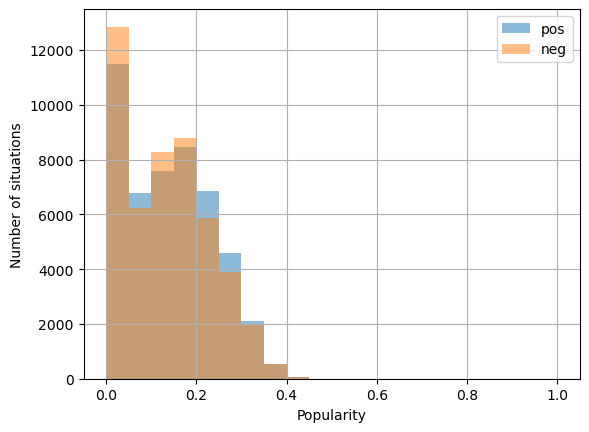

In [7]:
df.loc[df['exposure']==1]['popularity'].hist(range = [0,1], bins = 20,label = 'pos', alpha = 0.5)
df.loc[df['exposure']==0]['popularity'].hist(range = [0,1], bins = 20,label = 'neg', alpha = 0.5)

plt.xlabel('Popularity')
plt.ylabel('Number of situations')

plt.legend()

In [8]:
len(df)

96986

### a) Overall

In [9]:
treated_p = df.loc[df['exposure']==1]['outcome'].value_counts(normalize = True)[1]
control_p = df.loc[df['exposure']==0]['outcome'].value_counts(normalize = True)[1]

print('ATE =', round(100*(treated_p - control_p),2),'%')


treated_p_not = df.loc[df['exposure']==1]['outcome'].value_counts(normalize = True)[0]
control_p_not = df.loc[df['exposure']==0]['outcome'].value_counts(normalize = True)[0]

print('ATE NOT =', round(100*(treated_p_not - control_p_not),2),'%')



ys = []

for iteration in range(1000):
    pos_tmp = df.loc[df['exposure']==1].sample(round(len(df)/2), replace = True)['outcome'].value_counts(normalize = True)[1]
    neg_tmp = df.loc[df['exposure']==0].sample(round(len(df)/2), replace = True)['outcome'].value_counts(normalize = True)[1]   

    y_tmp = pos_tmp - neg_tmp

    ys.append(y_tmp)
    
    

print('lower_error = ', round(100*np.percentile(np.array(ys), 2.5),2),'%')
print('upper_error = ', round(100*np.percentile(np.array(ys),97.5),2),'%')

ATE = 14.22 %
ATE NOT = -14.22 %
lower_error =  13.73 %
upper_error =  14.73 %


In [10]:
treated_p - control_p

0.14224733466685915

In [11]:
treated_p/control_p

1.8348057606196297

In [12]:
print(pd.crosstab(df['exposure'],df['outcome'], margins = True).to_latex())

\begin{tabular}{lrrr}
\toprule
outcome &      0 &      1 &    All \\
exposure &        &        &        \\
\midrule
0        &  40230 &   8263 &  48493 \\
1        &  33332 &  15161 &  48493 \\
All      &  73562 &  23424 &  96986 \\
\bottomrule
\end{tabular}



In [13]:
t1 = df.loc[df['exposure']==1]['outcome'].values

In [14]:
t2 = df.loc[df['exposure']==0]['outcome'].values

In [15]:
matrix_paired = np.matrix([[0, 0], [0, 0]])
for i in range(len(t1)):
    matrix_paired[t1[i],t2[i]]+=1

In [16]:
np.mean(t1- t2)

0.14224733466685913

In [17]:
matrix_paired

matrix([[28111,  5221],
        [12119,  3042]])

In [18]:
from scipy.stats import chisquare
chisquare([28111,  5221, 12119,  3042])

Power_divergenceResult(statistic=31816.41265749696, pvalue=0.0)

In [19]:
from pprint import pprint
from statsmodels.stats.contingency_tables import mcnemar
p = mcnemar(matrix_paired)
print(p)

pvalue      0.0
statistic   5221.0


In [20]:
entry = {}
entry['ATE'] = treated_p - control_p
entry['lower_error'] = np.percentile(np.array(ys), 2.5)
entry['upper_error'] = np.percentile(np.array(ys), 97.5)
pd.DataFrame([entry]).to_pickle('tmp/ate')

In [21]:
t1 = pd.read_pickle('tmp/contingency_randomized')
t2 = pd.read_pickle('tmp/contingency_reversed')
t3 = pd.crosstab(df['exposure'],df['outcome'], margins = True)

In [22]:
from scipy.stats.contingency import relative_risk

list_r = []
for cnt,t in enumerate([t1,t2,t3]):
    entry = {}
    entry['type'] = ['Regular','Reversed','Randomized'][cnt]
    result = relative_risk(t.values[1,1], t.values[1,0]+t.values[1,1],  
                       t.values[0,1], t.values[0,0]+t.values[0,1])
    print(result.relative_risk, result.confidence_interval(confidence_level=0.95)[0], 
      result.confidence_interval(confidence_level=0.95)[1])
    
    entry['RTE'] = result.relative_risk
    entry['lower_error'] = result.confidence_interval(confidence_level=0.95)[0]
    entry['upper_error'] = result.confidence_interval(confidence_level=0.95)[1]
    list_r.append(entry)

1.074937370656791 1.0471073219577673 1.103507087195346
1.8109307485694264 1.7692447835787024 1.853598895162909
1.8348057606196297 1.7919019956666025 1.8787367765337006


In [23]:
a1 = pd.read_pickle('tmp/ate_randomized')
a2 = pd.read_pickle('tmp/ate_reversed')
a3 = pd.read_pickle('tmp/ate')

In [24]:
a1['type'] = 'randomized'
a2['type'] = 'reversed'
a3['type'] = 'regular'

In [25]:
df_plt = pd.concat([a1,a2,a3])

Text(0, 0.5, 'Food item')

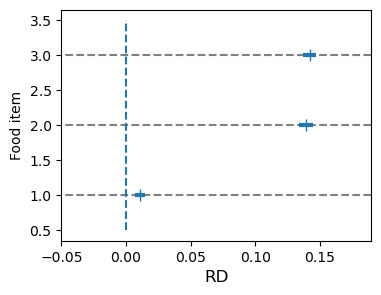

In [26]:
fix, axes = plt.subplots(1,1, figsize = (4,3))

types = []

c = 0
for cnt,row in df_plt.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(3-c, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[3-c], xerr = (np.array([row['ATE'] - row['lower_error']]), 
                                             np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    types.append(row['type'])
    c+=1
#plt.yticks(3-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.05,0.19])

plt.vlines(0,0.5,3.5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Food item')

Text(0, 0.5, 'Food item')

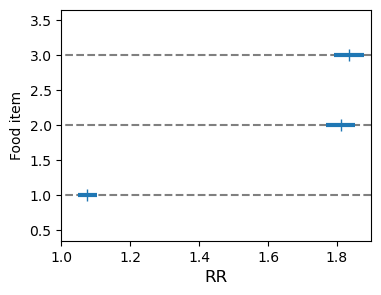

In [27]:
df_plt = pd.DataFrame(list_r)
fix, axes = plt.subplots(1,1, figsize = (4,3))

types = []

c = 0
for cnt,row in df_plt.sort_values(by = 'RTE', ascending = False).iterrows():
    plt.hlines(3-c, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['RTE']],[3-c], xerr = (np.array([row['RTE'] - row['lower_error']]), 
                                             np.array([row['upper_error']- row['RTE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    types.append(row['type'])
    c+=1
#plt.yticks(3-np.array(range(len(additions['LUNCH']))), [i for i in [i.replace('_',' ').capitalize() for i in types]]);

plt.xlim([1,1.9])

plt.vlines(0,0.5,3.5, linestyle = '--')

plt.xlabel('RR', fontsize =12)
plt.ylabel('Food item')

In [28]:
treated_p = df.loc[df['exposure']==1]['outcome'].value_counts(normalize = True)[1]
control_p = df.loc[df['exposure']==0]['outcome'].value_counts(normalize = True)[1]

print('ATE =', round(100*(treated_p - control_p),2),'%')

ys = []
for iteration in range(1000):
    pos_tmp = df.loc[df['exposure']==1].sample(round(len(df)/2), replace = True)['outcome'].value_counts(normalize = True)[1]
    neg_tmp = df.loc[df['exposure']==0].sample(round(len(df)/2), replace = True)['outcome'].value_counts(normalize = True)[1]   

    y_tmp = pos_tmp - neg_tmp

    ys.append(y_tmp)

print('lower_error = ', round(100*np.percentile(np.array(ys), 2.5),2),'%')
print('upper_error = ', round(100*np.percentile(np.array(ys),97.5),2),'%')



ATE = 14.22 %
lower_error =  13.71 %
upper_error =  14.74 %


### b.1) Per food type

In [29]:
anchors = {
    'BREAKFAST': ['coffee','tea'],
    'LUNCH': ['meal'],
    'AFTERNOON SNACK': ['coffee','tea']
}

times = {
    'BREAKFAST': '06:00-11:00',
    'LUNCH': '11:00-14.30',
    'AFTERNOON SNACK': '14.30-20:00'
}

additions = {
    'BREAKFAST': ['dessert', 'fruit', 'pastry'],
    'LUNCH': ['condiment',
             'dessert',
             'fruit',
             'pastry',
             'salad',
             'soft drink',
             'soup'],
    'AFTERNOON SNACK': ['dessert', 'fruit', 'pastry']
}

In [30]:
list_viz = []

for addition in additions['LUNCH']:
    df_tmp = df.loc[(df['addition'] == addition)]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(addition, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))

    entry['matched_pairs_of_situations'] = len(df_tmp)/2
    
    list_viz.append(entry)
    


condiment ATE = 23.94 %
dessert ATE = 10.69 %
fruit ATE = 14.33 %
pastry ATE = 11.67 %
salad ATE = 12.9 %
soft drink ATE = 10.06 %
soup ATE = 18.48 %


In [31]:
df_plot = pd.DataFrame(list_viz)
df_plot['type'] = additions['LUNCH']
df_plot.sort_values(by = 'ATE', ascending = False)

treated_p  control_p       ATE  lower_error  upper_error  \
0   0.278354   0.038998  0.239356     0.221458     0.257245   
6   0.378033   0.193184  0.184849     0.171344     0.196880   
2   0.324017   0.180710  0.143307     0.131365     0.154008   
4   0.188422   0.059402  0.129020     0.112741     0.145677   
3   0.361297   0.244627  0.116670     0.105959     0.127311   
1   0.166507   0.059558  0.106948     0.091899     0.122318   
5   0.189298   0.088740  0.100557     0.086288     0.113495   

   matched_pairs_of_situations        type  
0                       2795.0   condiment  
6                       9478.0        soup  
2                      12058.0       fruit  
4                       2643.0       salad  
3                      13911.0      pastry  
1                       3123.0     dessert  
5                       4485.0  soft drink

Text(0, 0.5, 'Food item')

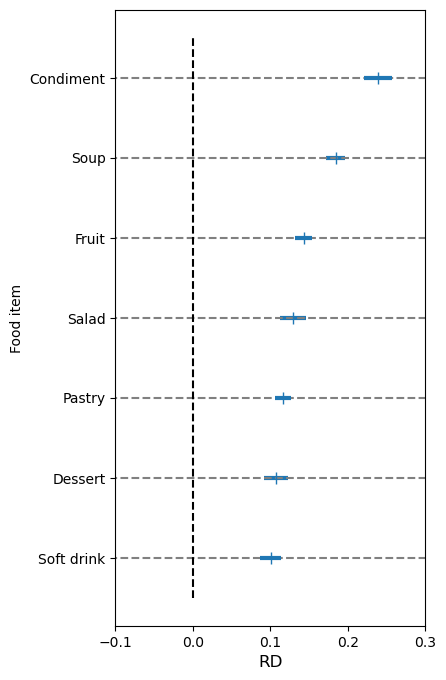

In [32]:
fix, axes = plt.subplots(1,1, figsize = (4,8))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(11-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[11-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    types.append(row['type'])
    c+=1
plt.yticks(11-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,4.5,11.5, linestyle = '--', color = 'black')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Food item')


### b.2) per meal

In [33]:
list_viz = []

for meal in additions.keys():
    df_tmp = df.loc[(df['MEAL']==meal)]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(meal, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))

    entry['matched_pairs_of_situations'] = len(df_tmp)/2
    
    entry['meal'] = meal
    
    list_viz.append(entry)
    

BREAKFAST ATE = 9.38 %
LUNCH ATE = 15.32 %
AFTERNOON SNACK ATE = 16.67 %


### b.3) per meal x food type

In [34]:
list_viz = []

for meal in ['BREAKFAST', 'LUNCH', 'AFTERNOON SNACK']:
    for addition in additions[meal]:
        df_tmp = df.loc[(df['MEAL']==meal) & (df['addition']==addition)]

        try:
            treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
            control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]
        except:
            print(meal, addition)
            continue
        
        print(meal, addition,  'ATE =', round(100*(treated_p - control_p),2),'%')

        entry = {}

        entry['ATE'] = treated_p - control_p
        
        entry['RR'] = treated_p/control_p

        ys = []
        ys_rr = []
        for iteration in range(1000):
            try:
                pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
                neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   
            except:
                continue
            y_tmp = pos_tmp - neg_tmp

            ys.append(y_tmp)
            ys_rr.append(pos_tmp/neg_tmp)

        entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
        entry['upper_error'] = (np.percentile(np.array(ys),97.5))

        entry['lower_error_rr'] = (np.percentile(np.array(ys_rr), 2.5))
        entry['upper_error_rr'] = (np.percentile(np.array(ys_rr),97.5))

        entry['meal'] = meal
        entry['addition'] = addition
        
        print(meal, addition,  'lower', round(100*((np.percentile(np.array(ys), 2.5))),2),'%')
        print(meal, addition,  'upper', round(100*((np.percentile(np.array(ys), 97.5))),2),'%')

        list_viz.append(entry)

BREAKFAST dessert ATE = 5.78 %
BREAKFAST dessert lower 3.39 %
BREAKFAST dessert upper 8.17 %
BREAKFAST fruit ATE = 7.34 %
BREAKFAST fruit lower 4.89 %
BREAKFAST fruit upper 9.95 %
BREAKFAST pastry ATE = 9.74 %
BREAKFAST pastry lower 8.27 %
BREAKFAST pastry upper 11.22 %
LUNCH condiment ATE = 23.94 %
LUNCH condiment lower 22.11 %
LUNCH condiment upper 25.87 %
LUNCH dessert ATE = 12.95 %
LUNCH dessert lower 10.72 %
LUNCH dessert upper 15.12 %
LUNCH fruit ATE = 14.83 %
LUNCH fruit lower 13.64 %
LUNCH fruit upper 16.02 %
LUNCH pastry ATE = 11.59 %
LUNCH pastry lower 10.22 %
LUNCH pastry upper 13.11 %
LUNCH salad ATE = 12.9 %
LUNCH salad lower 11.09 %
LUNCH salad upper 14.64 %
LUNCH soft drink ATE = 10.06 %
LUNCH soft drink lower 8.74 %
LUNCH soft drink upper 11.53 %
LUNCH soup ATE = 18.48 %
LUNCH soup lower 17.19 %
LUNCH soup upper 19.78 %
AFTERNOON SNACK dessert ATE = 7.61 %
AFTERNOON SNACK dessert lower 4.5 %
AFTERNOON SNACK dessert upper 10.71 %
AFTERNOON SNACK fruit ATE = 8.58 %
AFTERN

In [35]:
df_plot = pd.DataFrame(list_viz)

In [36]:
df_plot

ATE        RR  lower_error  upper_error  lower_error_rr  \
0   0.057769  6.800000     0.033865     0.081673        3.124306   
1   0.073409  4.750000     0.048899     0.099511        2.683772   
2   0.097408  1.283207     0.082732     0.112203        1.235094   
3   0.239356  7.137615     0.221109     0.258676        5.968071   
4   0.129489  2.828571     0.107233     0.151239        2.323131   
5   0.148323  1.772052     0.136372     0.160188        1.690526   
6   0.115946  3.033175     0.102162     0.131081        2.635555   
7   0.129020  3.171975     0.110859     0.146425        2.701725   
8   0.100557  2.133166     0.087402     0.115273        1.921853   
9   0.184849  1.956854     0.171864     0.197829        1.860819   
10  0.076087  2.195122     0.045031     0.107143        1.592593   
11  0.085837  2.538462     0.034335     0.137339        1.399722   
12  0.210556  2.297203     0.181598     0.237798        2.038030   

    upper_error_rr             meal    addition  
0        31.000000        BREAKFAST     dessert  
1        10.502500        BREAKFAST       fruit  
2         1.331499        BREAKFAST      pastry  
3         8.648842            LUNCH   condiment  
4         3.444661            LUNCH     dessert  
5         1.854315            LUNCH       fruit  
6         3.489095            LUNCH      pastry  
7         3.755952            LUNCH       salad  
8         2.395664            LUNCH  soft drink  
9         2.057594            LUNCH        soup  
10        3.121212  AFTERNOON SNACK     dessert  
11        5.334375  AFTERNOON SNACK       fruit  
12        2.602337  AFTERNOON SNACK      pastry

In [37]:
randomized = pd.read_pickle('tmp/randomized_estimates')
reverse = pd.read_pickle('tmp/reversed_estimates')

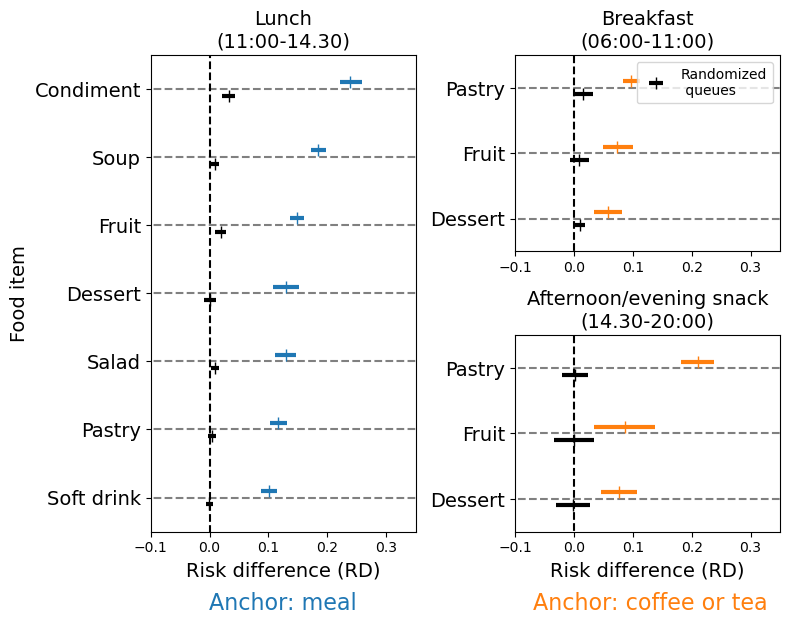

In [38]:
plt.figure(figsize = (8,6))

for cnt,meal in enumerate(['LUNCH', 'BREAKFAST','AFTERNOON SNACK']):
    if cnt==0:
        sbplt = plt.subplot(2,2,(1,3))
        sbplt.set_ylim([-0.5,6.5])
    if cnt==1:
        sbplt = plt.subplot(2,2,2)
        sbplt.set_ylim([-0.5,2.5])
    if cnt==2:
        sbplt = plt.subplot(2,2,4)
        sbplt.set_ylim([-0.5,2.5])
        
    types = []

    c = 0
    
    if meal =='LUNCH':
        color= 'tab:blue'
    else:
        color = 'tab:orange'
        
    for cnt,row in (df_plot.loc[df_plot['meal']==meal]).sort_values(by = 'ATE', ascending = True).reset_index().iterrows():
        sbplt.hlines(cnt, -1,4, color = 'gray', linestyle = '--')
        
        sbplt.errorbar([row['ATE']],[c+0.1], xerr = (np.array([row['ATE'] - row['lower_error']]), 
                     np.array([row['upper_error']- row['ATE']])),
                     fmt = '|', markersize= 8,color = color, linewidth = 3)
        
        baseline = randomized.loc[(randomized['meal']==meal) & (randomized['addition']==row['addition'])].iloc[0]
        
        if meal=='BREAKFAST' and cnt==0:
            sbplt.errorbar([baseline['ATE']],[c-0.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                     np.array([baseline['upper_error']- baseline['ATE']])),
                     fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
            sbplt.legend(loc = 'upper right')
        else:
            sbplt.errorbar([baseline['ATE']],[c-0.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                     np.array([baseline['upper_error']- baseline['ATE']])),
                     fmt = '|', markersize= 8,color = 'black', linewidth = 3)
        
        r = reverse.loc[(randomized['meal']==meal) & (reverse['addition']==row['addition'])].iloc[0]
        
        '''
        if meal=='BREAKFAST' and cnt==0:
            sbplt.errorbar([r['ATE']],[c-0], xerr = (np.array([r['ATE'] - r['lower_error']]), 
                     np.array([r['upper_error']- r['ATE']])),
                     fmt = '|', markersize= 8,color = 'gray', linewidth = 3, label = 'Reversed\n queues')
            sbplt.legend(loc = 'upper right')
        else:
            sbplt.errorbar([r['ATE']],[c-0], xerr = (np.array([r['ATE'] - r['lower_error']]), 
                     np.array([r['upper_error']- r['ATE']])),
                     fmt = '|', markersize= 8,color = 'gray', linewidth = 3)
        
        '''
        types.append(row['addition'])
        
        c+=1
        
    sbplt.set_yticks(np.array(range(len(additions[meal]))))
    sbplt.set_yticklabels([i.replace('_',' ').capitalize() for i in types], fontsize = 14)

    sbplt.set_xlim([-0.1,0.35])
    

    sbplt.vlines(0,-1,7, linestyle = '--', color = 'black')

    if meal!='BREAKFAST':
        sbplt.set_xlabel('Risk difference (RD)', fontsize =14)
    

        
    if meal =='AFTERNOON SNACK':
        sbplt.set_title('AFTERNOON/EVENING SNACK'.lower().capitalize()+'\n('+times[meal]+')' , fontsize = 14)
    else:
        sbplt.set_title(meal.lower().capitalize()+'\n('+times[meal]+')',  fontsize = 14)
    
    if meal == 'LUNCH':
        sbplt.set_ylabel('Food item', fontsize = 14)
   
plt.tight_layout()

plt.text(x = -0.62, y = -1.7, s='Anchor: meal', fontsize= 16, color = 'tab:blue') 
plt.text(x = -0.07, y = -1.7, s='Anchor: coffee or tea', fontsize= 16, color = 'tab:orange') 


plt.savefig(FIGURES_DIR+'fig2.pdf', bbox_inches='tight')

### Relative version

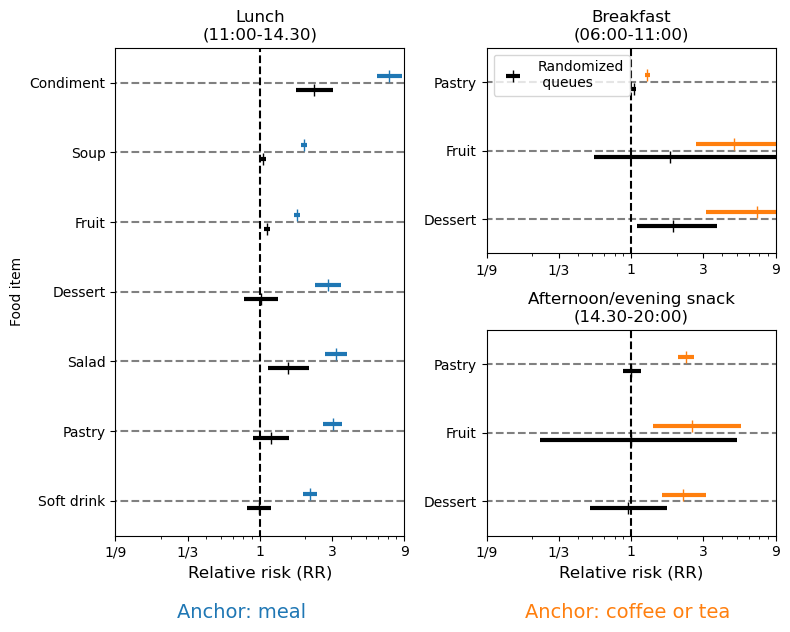

In [39]:
plt.figure(figsize = (8,6))

for cnt,meal in enumerate(['LUNCH', 'BREAKFAST','AFTERNOON SNACK']):
    if cnt==0:
        sbplt = plt.subplot(2,2,(1,3))
        sbplt.set_ylim([-0.5,6.5])
    if cnt==1:
        sbplt = plt.subplot(2,2,2)
        sbplt.set_ylim([-0.5,2.5])
    if cnt==2:
        sbplt = plt.subplot(2,2,4)
        sbplt.set_ylim([-0.5,2.5])
        
    types = []

    c = 0
    
    if meal =='LUNCH':
        color= 'tab:blue'
    else:
        color = 'tab:orange'
        
    for cnt,row in (df_plot.loc[df_plot['meal']==meal]).sort_values(by = 'ATE', ascending = True).reset_index().iterrows():
        sbplt.hlines(cnt, -1,10, color = 'gray', linestyle = '--')
        
        sbplt.errorbar([row['RR']],[c+0.1], xerr = (np.array([row['RR'] - row['lower_error_rr']]), 
                     np.array([row['upper_error_rr']- row['RR']])),
                     fmt = '|', markersize= 8,color = color, linewidth = 3)
        
        baseline = randomized.loc[(randomized['meal']==meal) & (randomized['addition']==row['addition'])].iloc[0]
        
        if meal=='BREAKFAST' and cnt==0:
            sbplt.errorbar([baseline['RR']],[c-0.1], xerr = (np.array([baseline['RR'] - baseline['lower_error_rr']]), 
                     np.array([baseline['upper_error_rr']- baseline['RR']])),
                     fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
            sbplt.legend(loc = 'upper left')
        else:
            sbplt.errorbar([baseline['RR']],[c-0.1], xerr = (np.array([baseline['RR'] - baseline['lower_error_rr']]), 
                     np.array([baseline['upper_error_rr']- baseline['RR']])),
                     fmt = '|', markersize= 8,color = 'black', linewidth = 3)
        
        '''
        r = reverse.loc[(randomized['meal']==meal) & (reverse['addition']==row['addition'])].iloc[0]
        
        if meal=='BREAKFAST' and cnt==0:
            sbplt.errorbar([r['RR']],[c-0], xerr = (np.array([r['RR'] - r['lower_error_rr']]), 
                     np.array([r['upper_error_rr']- r['RR']])),
                     fmt = '|', markersize= 8,color = 'gray', linewidth = 3, label = 'Reversed\n queues')
            sbplt.legend(loc = 'upper right')
        else:
            sbplt.errorbar([r['RR']],[c-0], xerr = (np.array([r['RR'] - r['lower_error_rr']]), 
                     np.array([r['upper_error_rr']- r['RR']])),
                     fmt = '|', markersize= 8,color = 'gray', linewidth = 3)
        '''
        types.append(row['addition'])
        c+=1
        
    sbplt.set_yticks(np.array(range(len(additions[meal]))))
    sbplt.set_yticklabels([i.replace('_',' ').capitalize() for i in types])

    sbplt.set_xlim([-1,9])
    

    #sbplt.vlines(0,-1,7, linestyle = '--')
    sbplt.vlines(1,-1,len(types)+2, linestyle = '--', color = 'black')
    if meal!='BREAKFAST':
        sbplt.set_xlabel('Relative risk (RR)', fontsize =12)
    

        
    if meal =='AFTERNOON SNACK':
        sbplt.set_title('AFTERNOON/EVENING SNACK'.lower().capitalize()+'\n('+times[meal]+')')
    else:
        sbplt.set_title(meal.lower().capitalize()+'\n('+times[meal]+')')
    
    if meal == 'LUNCH':
        sbplt.set_ylabel('Food item')
        
    sbplt.set_xscale('log', base = 9)
    sbplt.set_xticks([1/9,1/3,1,3, 9])
    sbplt.set_xlim([1/9,9])

    sbplt.set_xticklabels(['1/9','1/3','1','3','9'])
   
plt.tight_layout()

plt.text(x = 0.001, y = -1.7, s='Anchor: meal', fontsize= 14, color = 'tab:blue') 
plt.text(x = 0.2, y = -1.7, s='Anchor: coffee or tea', fontsize= 14, color = 'tab:orange') 

plt.savefig(FIGURES_DIR+'fig3.pdf', bbox_inches='tight')


### Sensitivity analysis per food type

In [40]:
def amplify(l,G):
    return (l*G - 1)/(l - G)

In [41]:
amplify(l = 2, G = 1.17)

1.6144578313253009

In [42]:
additions['LUNCH']

['condiment', 'dessert', 'fruit', 'pastry', 'salad', 'soft drink', 'soup']

In [43]:
gammas = {'condiment': 7.22,
    'dessert': 2.61,
    'fruit': 1.98,
    'pastry': 2.62,
    'salad': 2.89,
    'soft_drink': 2.03,
    'soup': 2.28}

In [44]:
sorted_values = dict(sorted(gammas.items(), key=lambda item: item[1], reverse = True)).keys()

In [45]:
import matplotlib.patches as mpatches

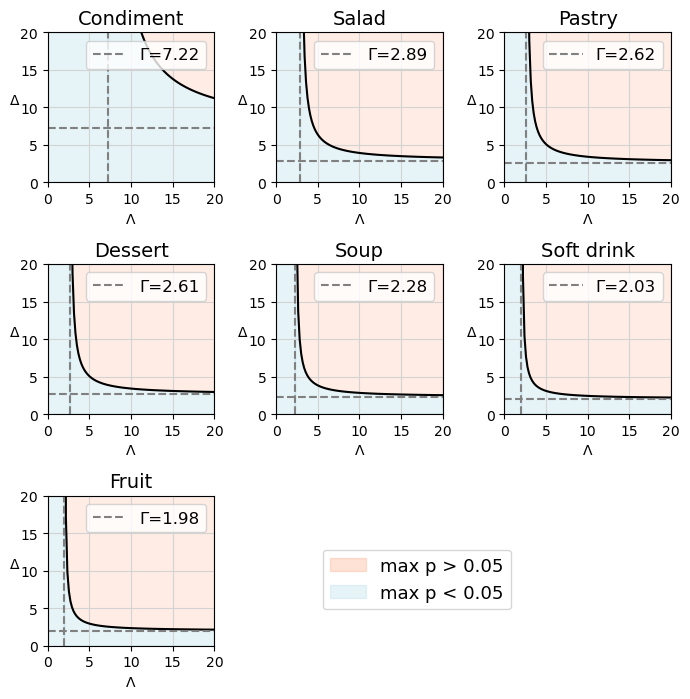

In [46]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(3,3,figsize= (7,7.1))

for i,addition in enumerate(sorted_values):
    sbplt = ax[ int(i/3), i%3]
    
    
    sbplt.set_title(addition.replace("_"," ").capitalize(), fontsize= 14)
    
    x = np.linspace(gammas[addition]+0.01, 20, 100)
    y = [amplify(i, gammas[addition]) for i in x]
    sbplt.plot(x,y, color = 'black')
    
    sbplt.hlines(gammas[addition], 0, 20, linestyle = '--', label = 'Γ='+str(gammas[addition]), color = 'gray')
    sbplt.vlines(gammas[addition], 0, 20, linestyle = '--', color = 'gray')
    sbplt.grid(True, color = 'lightgray')
    
    sbplt.set_xlim([0,20])
    sbplt.set_ylim([0,20])
    
    sbplt.set_xlabel('Λ')
    sbplt.set_ylabel('Δ', rotation = 0)

    sbplt.set_xticks([0,5,10,15,20])
    sbplt.set_yticks([0,5,10,15,20])
    
    #sbplt.text(1.3,1.5,'max p > 0.05', color = 'teal')
    #sbplt.text(15,15,'max p < 0.05', color = 'brown')
    
    sbplt.fill_between(x, y, 20, alpha = 0.2,color = 'lightsalmon')

    sbplt.fill_between(x, y, color = 'lightblue', alpha = 0.3)
    sbplt.fill_between([0,gammas[addition]+0.01],[20,20], color = 'lightblue', alpha = 0.3)
    sbplt.legend(loc = 'upper right', fontsize= 12)
    
sbplt = ax[2, 2]

sbplt.set_xticks([])
sbplt.set_yticks([])

sbplt.spines["right"].set_visible(False)
sbplt.spines["left"].set_visible(False)
sbplt.spines["top"].set_visible(False)
sbplt.spines["bottom"].set_visible(False)


sbplt = ax[2, 1]

sbplt.set_xticks([])
sbplt.set_yticks([])

sbplt.spines["right"].set_visible(False)
sbplt.spines["left"].set_visible(False)
sbplt.spines["top"].set_visible(False)
sbplt.spines["bottom"].set_visible(False)

red_patch = mpatches.Patch(alpha = 0.3, color = 'lightsalmon', label='max p > 0.05')
blue_patch = mpatches.Patch(alpha = 0.3, color = 'lightblue', label='max p < 0.05')

plt.tight_layout()

fig.legend(handles=[red_patch, blue_patch], bbox_to_anchor = (0.75,0.23), fontsize= 13)


plt.savefig(FIGURES_DIR+'fig4.pdf', bbox_inches='tight')

In [47]:
gammas_breakfast = {'dessert': 3.31,
    'fruit': 3.38,
    'pastry': 1.43}

gammas_snack = {'dessert': 1.74,
    'fruit': 1.49,
    'pastry': 2.68}

sorted_values_br = dict(sorted(gammas_breakfast.items(), key=lambda item: item[1], reverse = True)).keys()
sorted_values_sn = dict(sorted(gammas_snack.items(), key=lambda item: item[1], reverse = True)).keys()

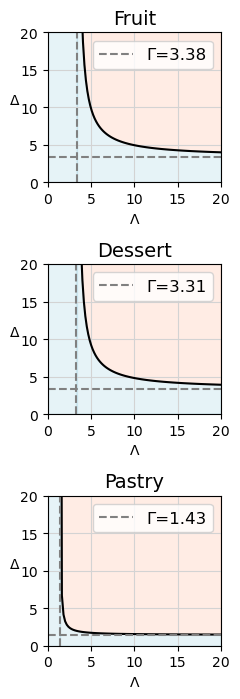

In [48]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(3,1,figsize= (2.5,7.1))

for i,addition in enumerate(sorted_values_br):
    sbplt = ax[i]
    
    sbplt.set_title(addition.replace("_"," ").capitalize(), fontsize= 14)
    
    x = np.linspace(gammas_breakfast[addition]+0.01, 20, 100)
    y = [amplify(i, gammas_breakfast[addition]) for i in x]
    sbplt.plot(x,y, color = 'black')
    
    sbplt.hlines(gammas_breakfast[addition], 0, 20, linestyle = '--', label = 'Γ='+str(gammas_breakfast[addition]), color = 'gray')
    sbplt.vlines(gammas_breakfast[addition], 0, 20, linestyle = '--', color = 'gray')
    sbplt.grid(True, color = 'lightgray')
    
    sbplt.set_xlim([0,20])
    sbplt.set_ylim([0,20])
    
    sbplt.set_xlabel('Λ')
    sbplt.set_ylabel('Δ', rotation = 0)

    sbplt.set_xticks([0,5,10,15,20])
    sbplt.set_yticks([0,5,10,15,20])
    
    #sbplt.text(1.3,1.5,'max p > 0.05', color = 'teal')
    #sbplt.text(15,15,'max p < 0.05', color = 'brown')
    
    sbplt.fill_between(x, y, 20, alpha = 0.2,color = 'lightsalmon')

    sbplt.fill_between(x, y, color = 'lightblue', alpha = 0.3)
    sbplt.fill_between([0,gammas_breakfast[addition]+0.01],[20,20], color = 'lightblue', alpha = 0.3)
    sbplt.legend(loc = 'upper right', fontsize= 12)


plt.tight_layout()

plt.savefig(FIGURES_DIR+'fig5.pdf', bbox_inches='tight')

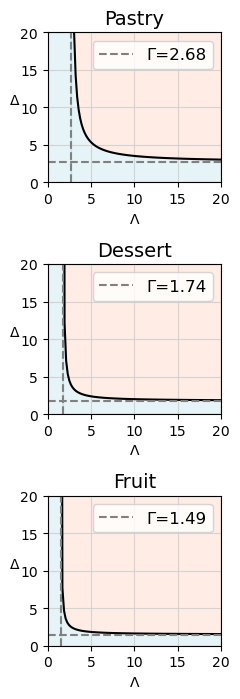

In [49]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(3,1, figsize= (2.5, 7.1))

for i,addition in enumerate(sorted_values_sn):
    sbplt = ax[i]
    
    sbplt.set_title(addition.replace("_"," ").capitalize(), fontsize= 14)
    
    x = np.linspace(gammas_snack[addition]+0.01, 20, 100)
    y = [amplify(i, gammas_snack[addition]) for i in x]
    sbplt.plot(x,y, color = 'black')
    
    sbplt.hlines(gammas_snack[addition], 0, 20, linestyle = '--', label = 'Γ='+str(gammas_snack[addition]), color = 'gray')
    sbplt.vlines(gammas_snack[addition], 0, 20, linestyle = '--', color = 'gray')
    sbplt.grid(True, color = 'lightgray')
    
    sbplt.set_xlim([0,20])
    sbplt.set_ylim([0,20])
    
    sbplt.set_xlabel('Λ')
    sbplt.set_ylabel('Δ', rotation = 0)

    sbplt.set_xticks([0,5,10,15,20])
    sbplt.set_yticks([0,5,10,15,20])
    
    #sbplt.text(1.3,1.5,'max p > 0.05', color = 'teal')
    #sbplt.text(15,15,'max p < 0.05', color = 'brown')
    
    sbplt.fill_between(x, y, 20, alpha = 0.2,color = 'lightsalmon')

    sbplt.fill_between(x, y, color = 'lightblue', alpha = 0.3)
    sbplt.fill_between([0,gammas_snack[addition]+0.01],[20,20], color = 'lightblue', alpha = 0.3)
    sbplt.legend(loc = 'upper right', fontsize= 12)


plt.tight_layout()

plt.savefig(FIGURES_DIR+'fig6.pdf', bbox_inches='tight')

### c) Per shop

In [50]:
len(df['shop'].unique())

12

In [51]:
len(df.loc[df['addition']=='pastry']['shop'].unique())

12

In [52]:
df_condiments = df.loc[df['addition']=='pastry']

In [53]:
list_viz = []

for shop in df_condiments['shop'].unique():
    
    print(shop)
    df_tmp = df_condiments.loc[df_condiments['shop'] == shop]

    try:
        treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
        control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]
    except KeyError as e:
        continue
        print('skipping', shop, ', no instances')
        
    print('ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(100):
        try:
            pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   
        except KeyError as e:
            pos_tmp = 0
        
        try:
            neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        except KeyError as e:
            neg_tmp = 0
       
        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))

    entry['matched_pairs_of_situations'] = len(df_tmp)/2
    entry['SHOP'] = shop
    
    list_viz.append(entry)
    


Esplanade
ATE = 21.0 %
Cafeteria ELA
ATE = 9.15 %
Atlantide
ATE = 7.11 %
Cafeteria BC
ATE = 13.34 %
Arcadie
ATE = 15.28 %
Corbusier
ATE = 8.15 %
Ornithorynque
ATE = 11.7 %
Le Klee by Takinoa
ATE = 13.36 %
Epicure
ATE = 3.64 %
Puur
ATE = 10.8 %
Vinci
ATE = 7.04 %
Parmentier
ATE = 11.25 %


In [54]:
df_plot = pd.DataFrame(list_viz)

In [55]:
df_plot['RTE'] = df_plot['treated_p']/ df_plot['control_p']

In [56]:
df_plot.sort_values(by = 'RTE')

treated_p  control_p       ATE  lower_error  upper_error  \
8    0.290909   0.254545  0.036364    -0.127273     0.181818   
2    0.376016   0.304878  0.071138     0.041260     0.109180   
5    0.426343   0.344887  0.081456     0.017244     0.122227   
1    0.471967   0.380474  0.091492     0.071485     0.120439   
7    0.500000   0.366379  0.133621     0.046983     0.213470   
4    0.414311   0.261484  0.152827     0.113030     0.188251   
9    0.250000   0.142045  0.107955     0.028409     0.199148   
6    0.266332   0.149318  0.117014     0.090416     0.147918   
0    0.450739   0.240764  0.209975     0.185252     0.242965   
10   0.144154   0.073780  0.070375     0.043672     0.105079   
3    0.273114   0.139745  0.133369     0.105739     0.160773   
11   0.160356   0.047884  0.112472     0.089087     0.143124   

    matched_pairs_of_situations                SHOP       RTE  
8                          55.0             Epicure  1.142857  
2                        1476.0           Atlantide  1.233333  
5                         577.0           Corbusier  1.236181  
1                        3585.0       Cafeteria ELA  1.240469  
7                         232.0  Le Klee by Takinoa  1.364706  
4                        1132.0             Arcadie  1.584459  
9                         176.0                Puur  1.760000  
6                        1393.0       Ornithorynque  1.783654  
0                        1624.0           Esplanade  1.872123  
10                        881.0               Vinci  1.953846  
3                        1882.0        Cafeteria BC  1.954373  
11                        898.0          Parmentier  3.348837

In [57]:
df_plot.to_pickle('tmp/shops')

In [58]:
randomized = pd.read_pickle('tmp/shops_randomized_pastry')

In [59]:
randomized[['SHOP','ATE']]

SHOP       ATE
0            Esplanade  0.001840
1        Cafeteria ELA  0.014694
2            Atlantide  0.040138
3              Arcadie  0.001715
4        Ornithorynque  0.018252
5            Corbusier -0.036613
6   Le Klee by Takinoa  0.028249
7         Cafeteria BC  0.010280
8              Epicure  0.000000
9                 Puur -0.041379
10               Vinci  0.006015
11          Parmentier  0.002449

In [60]:
t = df_plot[['SHOP','ATE']].merge(randomized[['SHOP','ATE']], on = 'SHOP')

In [61]:
t['diff'] = t['ATE_x'] - t['ATE_y']

In [62]:
t.sort_values(by = 'diff', ascending = False)

SHOP     ATE_x     ATE_y      diff
0            Esplanade  0.209975  0.001840  0.208135
4              Arcadie  0.152827  0.001715  0.151112
9                 Puur  0.107955 -0.041379  0.149334
3         Cafeteria BC  0.133369  0.010280  0.123088
5            Corbusier  0.081456 -0.036613  0.118069
11          Parmentier  0.112472  0.002449  0.110023
7   Le Klee by Takinoa  0.133621  0.028249  0.105372
6        Ornithorynque  0.117014  0.018252  0.098762
1        Cafeteria ELA  0.091492  0.014694  0.076798
10               Vinci  0.070375  0.006015  0.064360
8              Epicure  0.036364  0.000000  0.036364
2            Atlantide  0.071138  0.040138  0.031001

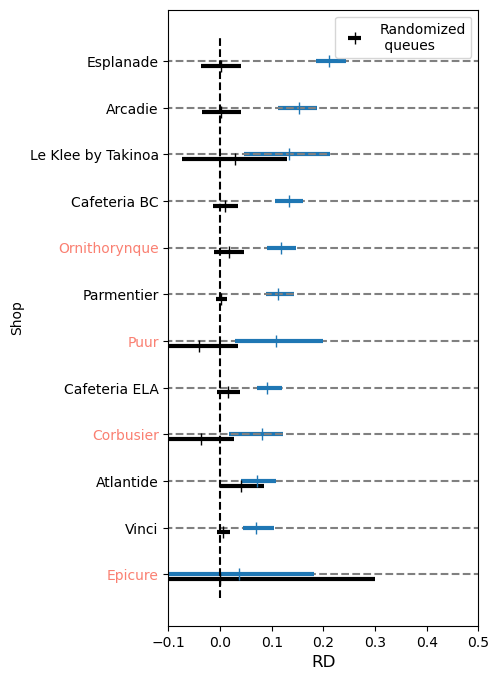

In [63]:
fix, axes = plt.subplots(1,1, figsize = (4,8))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(14-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[14-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    
    baseline = randomized.loc[(randomized['SHOP']==row['SHOP'])].iloc[0]
        
    if c==0:
        plt.errorbar([baseline['ATE']],[14-c-0.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                 np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
        plt.legend(loc = 'upper right')
    else:
        plt.errorbar([baseline['ATE']],[14-c-0.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                 np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
            
    types.append(row['SHOP'])
    
    c+=1
    
#plt.yticks(14-np.array(range(len(df['shop'].unique()))), ['Shop '+str(i+1) for i in range (12)]);

plt.yticks(14-np.array(range(len(df['shop'].unique()))), types);


my_colors =  ["black", "black", "black", "black", "salmon", "black", "salmon", "black","salmon", "black", "black", "salmon"]

for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    
plt.xlim([-0.1,0.5])

plt.vlines(0,2.5,14.5, linestyle = '--', color = 'black')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Shop')

plt.savefig(FIGURES_DIR+'fig7.pdf', bbox_inches='tight')

In [64]:
types

['Esplanade',
 'Arcadie',
 'Le Klee by Takinoa',
 'Cafeteria BC',
 'Ornithorynque',
 'Parmentier',
 'Puur',
 'Cafeteria ELA',
 'Corbusier',
 'Atlantide',
 'Vinci',
 'Epicure']

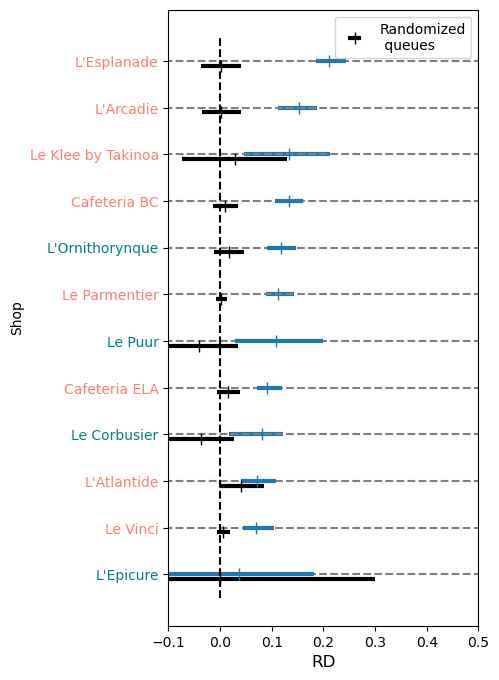

In [65]:
fix, axes = plt.subplots(1,1, figsize = (4,8))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(14-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[14-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    
    baseline = randomized.loc[(randomized['SHOP']==row['SHOP'])].iloc[0]
        
    if c==0:
        plt.errorbar([baseline['ATE']],[14-c-0.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                 np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
        plt.legend(loc = 'upper right')
    else:
        plt.errorbar([baseline['ATE']],[14-c-0.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                 np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
            
    types.append(row['SHOP'])
    
    c+=1
    
#plt.yticks(14-np.array(range(len(df['shop'].unique()))), ['Shop '+str(i+1) for i in range (12)]);



types = ["L'Esplanade",
 "L'Arcadie",
 'Le Klee by Takinoa',
 'Cafeteria BC',
 "L'Ornithorynque",
 'Le Parmentier',
 'Le Puur',
 'Cafeteria ELA',
 'Le Corbusier',
 "L'Atlantide",
 'Le Vinci',
 "L'Epicure"]

plt.yticks(14-np.array(range(len(df['shop'].unique()))), types);

my_colors =  ["salmon", "salmon", "salmon", "salmon", "teal", "salmon", "teal", "salmon","teal", "salmon", "salmon", "teal"]

for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
    
plt.xlim([-0.1,0.5])

plt.vlines(0,2.5,14.5, linestyle = '--', color = 'black')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Shop')

plt.savefig(FIGURES_DIR+'fig_layouts.pdf', bbox_inches='tight')

In [66]:
df['shop'].unique()

shops = ['Parmentier',
    'Arcadie',
    'Puur',
    'Vinci',
    'Corbusier',
    'Le Klee by Takinoa',
    'Esplanade',
    'Ornithorynque',
    'Cafeteria BC',
    'Atlantide']

In [67]:
shops = ['Cafeteria ELA', 'Arcadie', 'Atlantide', 'Ornithorynque',
       'Cafeteria BC', 'Corbusier', 'Esplanade', 'Le Klee by Takinoa',
       'Epicure', 'Puur', 'Parmentier', 'Vinci']

cash_registry = ['single',
 'single',
 'single',
 'multiple',
 'single',              
 'single',
 'multiple',
 'single',
 'multiple',
 'single',
'multiple',
 'single',
]

layout = ['directional',
 'directional',
 'directional',
 'directional',
 'directional',
 'directional',
 'mixed',
 'directional',
 'mixed',
 'directional',
  'mixed',
 'directional'
         ]

In [68]:
df_shops = pd.DataFrame()
df_shops['name'] = shops
df_shops['registries'] = cash_registry
df_shops['layout'] = layout

In [69]:
df_shops

name registries       layout
0        Cafeteria ELA     single  directional
1              Arcadie     single  directional
2            Atlantide     single  directional
3        Ornithorynque   multiple  directional
4         Cafeteria BC     single  directional
5            Corbusier     single  directional
6            Esplanade   multiple        mixed
7   Le Klee by Takinoa     single  directional
8              Epicure   multiple        mixed
9                 Puur     single  directional
10          Parmentier   multiple        mixed
11               Vinci     single  directional

In [70]:
df_shops['group'] = ((df_shops['registries']=='single') & \
                     (df_shops['layout']=='directional'))

In [71]:
df_shops['group2'] = ((df_shops['registries']=='single') | \
                      (df_shops['layout']=='directional'))

In [72]:
df_shops.loc[~df_shops['group']]['name'].values

array(['Ornithorynque', 'Esplanade', 'Epicure', 'Parmentier'],
      dtype=object)

In [73]:
df_shops.loc[~df_shops['group2']]['name'].values

array(['Esplanade', 'Epicure', 'Parmentier'], dtype=object)

In [74]:
list_viz = []

for i in range(2):
    
    if i==0:
        df_tmp = df.loc[df['shop'].isin(['Corbusier', 'Ornithorynque', 'Puur', 'Epicure'])]
    else:
        df_tmp = df.loc[~(df['shop'].isin(['Corbusier', 'Ornithorynque', 'Puur', 'Epicure']))]
    i+=1
    try:
        treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
        control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]
    except KeyError as e:
        continue
        print('skipping', shop, ', no instances')
        
    print('ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = (treated_p) - control_p
    
    ys = []
    for iteration in range(1000):
        try:
            pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   
        except KeyError as e:
            pos_tmp = 0
        
        try:
            neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        except KeyError as e:
            neg_tmp = 0
       
        y_tmp = (pos_tmp) - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))

    entry['matched_pairs_of_situations'] = len(df_tmp)/2
    entry['group'] = i
    
    list_viz.append(entry)

ATE = 16.77 %
ATE = 13.72 %


In [75]:
pd.DataFrame(list_viz)

treated_p  control_p       ATE  lower_error  upper_error  \
0   0.270606   0.102873  0.167733     0.156693     0.179780   
1   0.320912   0.183678  0.137234     0.131459     0.142817   

   matched_pairs_of_situations  group  
0                       7971.0      1  
1                      40522.0      2

Text(0, 0.5, 'Shop')

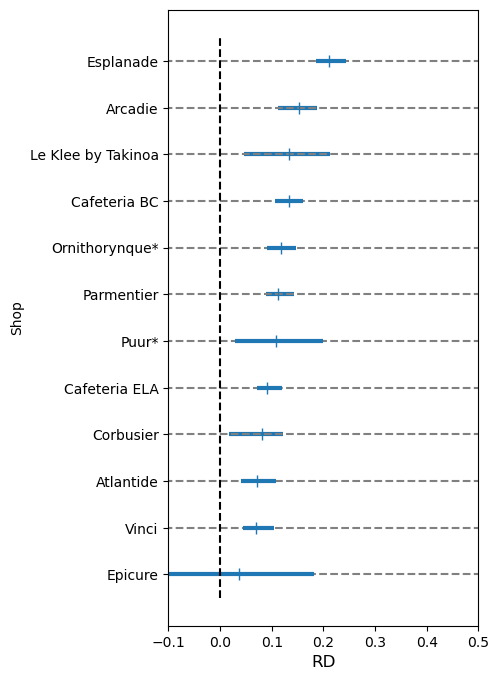

In [76]:
fix, axes = plt.subplots(1,1, figsize = (4,8))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(14-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[14-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    
    if row['SHOP'] in ['Ornithorynque', 'Puur']:
        types.append(row['SHOP']+'*')
    else: 
        types.append(row['SHOP'])
    c+=1
    
    
plt.yticks(14-np.array(range(len(df['shop'].unique()))), types);

plt.xlim([-0.1,0.5])

plt.vlines(0,2.5,14.5, linestyle = '--',color = 'black')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Shop')

### From here on, all additions and lunch + breakfast + afternoon snack are pulled together

### d) Delay

In [77]:
df = pd.read_pickle('tmp/3_meals_matched_situations')

In [78]:
df = df.reset_index()

In [79]:
df_pos = df.loc[df['exposure'] == 1].reset_index()
df_neg = df.loc[df['exposure'] == 0].reset_index()

In [80]:
len(df_pos)

48493

In [81]:
len(df_neg)

48493

In [82]:
sum(df['delay']<60) / len(df)

0.9821005093518652

In [83]:
df['delay'].median()

9.0

In [84]:
df['delay'].std()

16.38731133129576

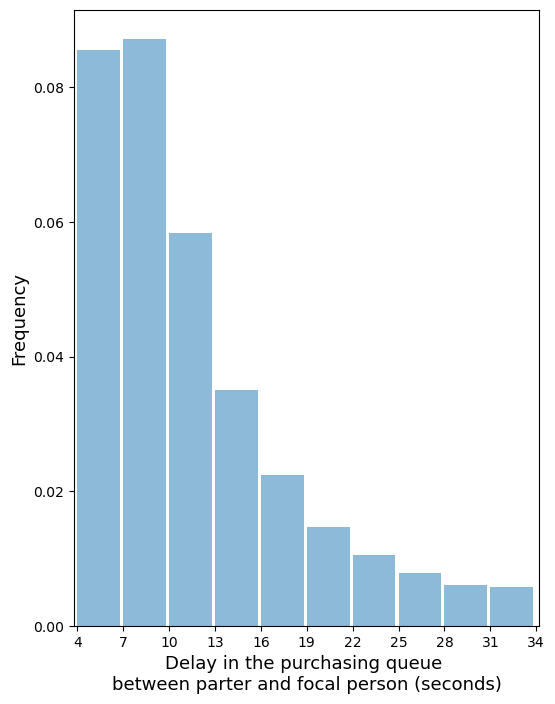

In [85]:
plt.subplots(1,1,figsize= (6,8))

df['delay'].hist(range = [4,34], bins = 10, width = 2.8, density = True, alpha = 0.5)

plt.grid(False)

plt.xticks(np.array(range(4,43,3)),range(4,43,3))
plt.xlim([3.8,34.2])

plt.xlabel('Delay in the purchasing queue \nbetween parter and focal person (seconds)', fontsize= 13)
plt.ylabel('Frequency', fontsize= 13)

plt.savefig(FIGURES_DIR+'fig8.pdf', bbox_inches='tight')

In [86]:
np.concatenate((np.arange(5,35,1.5),np.array([200])))

array([  5. ,   6.5,   8. ,   9.5,  11. ,  12.5,  14. ,  15.5,  17. ,
        18.5,  20. ,  21.5,  23. ,  24.5,  26. ,  27.5,  29. ,  30.5,
        32. ,  33.5, 200. ])

In [87]:
bins = np.concatenate((np.arange(3.5,35,1.5),np.array([200])))
#bins = np.concatenate((np.arange(3,42,2),np.array([200])))
list_viz_overall = []

for i in range(len(bins)-1):
    t = df.loc[((df['delay'] > bins[i]) & ( df['delay'] <= bins[i+1]))]

    try:
        treated_p = t.loc[t['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    except:
        treated_p = 0

    try:
        control_p = t.loc[t['exposure']==0]['outcome'].value_counts(normalize = True)[1]
    except:
        control_p = 0

    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    entry['RTE'] = treated_p/control_p

    ys = []
    ys_r = []
    for iteration in range(1000):
        try:
            pos_tmp = t.loc[t['exposure']==1].sample(len(t.loc[t['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   
        except KeyError as e:
            pos_tmp = 0

        try:
            neg_tmp = t.loc[t['exposure']==0].sample(len(t.loc[t['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        except KeyError as e:
            neg_tmp = 0

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)
        ys_r.append(pos_tmp/neg_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))

    entry['lower_error_r'] = (np.percentile(np.array(ys_r), 2.5))
    entry['upper_error_r'] = (np.percentile(np.array(ys_r),97.5))
    entry['bin'] = i

    list_viz_overall.append(entry)

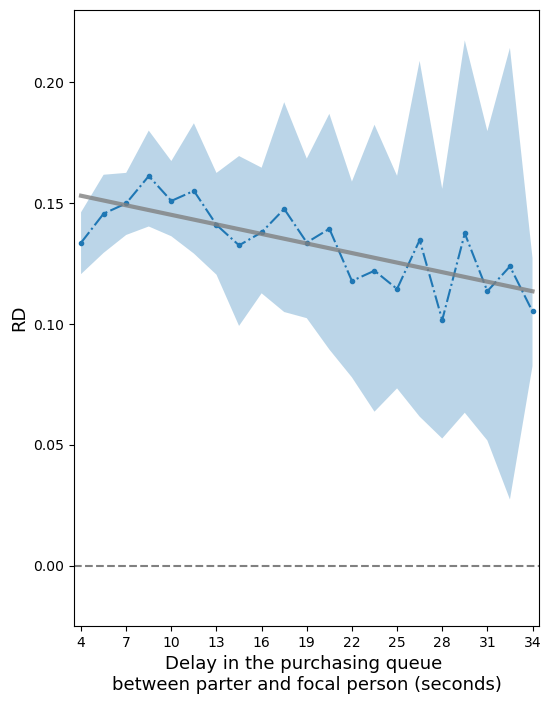

In [88]:
plt.subplots(1,1,figsize= (6,8))


gr = pd.DataFrame(list_viz_overall)

plt.plot(gr['bin'],gr['ATE'], linestyle = '-.', marker = 'o', markersize= 3)
plt.fill_between(gr['bin'], gr['lower_error'], gr['upper_error'], alpha = 0.3)

plt.xticks(gr['bin'], bins[:-1]);

plt.xlabel('Delay in the purchasing queue \nbetween parter and focal person (seconds)', fontsize= 13);
#plt.ylim([0,0.5])

slope, intercept, r, p, se = linregress(gr['bin'], gr['ATE'],
                                        alternative='two-sided')

if p<0.05:
    plt.plot(gr['bin'], intercept + slope*(gr['bin']),
               color = 'gray', linewidth = 3, alpha = 0.8)

else:
    plt.plot(gr['bin'], intercept + slope*(gr['bin']),
           color = 'gray',alpha = 0.3, linewidth = 3)


plt.xticks(gr['bin'][::2], [str(round(float(i+0.5))) for i in bins[:-1][::2]]);

plt.xlim(gr['bin'][::2][0]-0.3, gr['bin'].values[-1]+0.3)
plt.ylabel('RD', fontsize= 13)

plt.ylim([-0.025,0.23])

plt.hlines(0, gr['bin'][::2][0]-0.3, gr['bin'].values[-1]+0.3, linestyle = '--', color = 'gray')

plt.savefig(FIGURES_DIR+'fig9.pdf', bbox_inches='tight')

In [89]:
slope, p

(-0.001976778223853165, 8.714287565974914e-05)

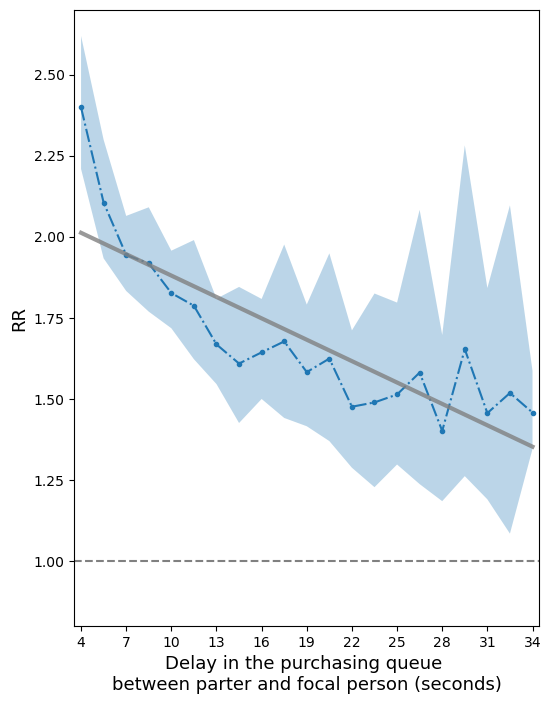

In [90]:
plt.subplots(1,1,figsize= (6,8))


gr = pd.DataFrame(list_viz_overall)

plt.plot(gr['bin'],gr['RTE'], linestyle = '-.', marker = 'o', markersize= 3)
plt.fill_between(gr['bin'], gr['lower_error_r'], gr['upper_error_r'], alpha = 0.3)

plt.xticks(gr['bin'], bins[:-1]);

plt.xlabel('Delay in the purchasing queue \nbetween parter and focal person (seconds)', fontsize= 13);
#plt.ylim([0,0.5])

slope, intercept, r, p, se = linregress(gr['bin'], gr['RTE'],
                                        alternative='two-sided')

if p<0.05:
    plt.plot(gr['bin'], intercept + slope*(gr['bin']),
               color = 'gray', linewidth = 3, alpha = 0.8)

else:
    plt.plot(gr['bin'], intercept + slope*(gr['bin']),
           color = 'gray',alpha = 0.3, linewidth = 3)


plt.xticks(gr['bin'][::2], [str(round(float(i+0.5))) for i in bins[:-1][::2]]);

plt.xlim(gr['bin'][::2][0]-0.3, gr['bin'].values[-1]+0.3)
plt.ylabel('RR', fontsize= 13)

plt.ylim([0.8,2.7])

plt.hlines(1, gr['bin'][::2][0]-0.3, gr['bin'].values[-1]+0.3, linestyle = '--', color = 'gray')

plt.savefig(FIGURES_DIR+'fig9_1.pdf', bbox_inches='tight')

In [91]:
slope, p

(-0.0329853640159296, 2.241163003010112e-06)

In [92]:
bins = np.concatenate((np.arange(3.5,35,6),np.array([200])))
#bins = np.concatenate((np.arange(3,42,2),np.array([200])))
list_viz_overall = []

for i in range(len(bins)-1):
    t = df.loc[((df['delay'] > bins[i]) & ( df['delay'] <= bins[i+1]))]

    try:
        treated_p = t.loc[t['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    except:
        treated_p = 0

    try:
        control_p = t.loc[t['exposure']==0]['outcome'].value_counts(normalize = True)[1]
    except:
        control_p = 0

    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    entry['RTE'] = treated_p/control_p

    ys = []
    ys_r = []
    for iteration in range(1000):
        try:
            pos_tmp = t.loc[t['exposure']==1].sample(len(t.loc[t['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   
        except KeyError as e:
            pos_tmp = 0

        try:
            neg_tmp = t.loc[t['exposure']==0].sample(len(t.loc[t['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        except KeyError as e:
            neg_tmp = 0

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)
        ys_r.append(pos_tmp/neg_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))

    entry['lower_error_r'] = (np.percentile(np.array(ys_r), 2.5))
    entry['upper_error_r'] = (np.percentile(np.array(ys_r),97.5))
    entry['bin'] = i

    list_viz_overall.append(entry)

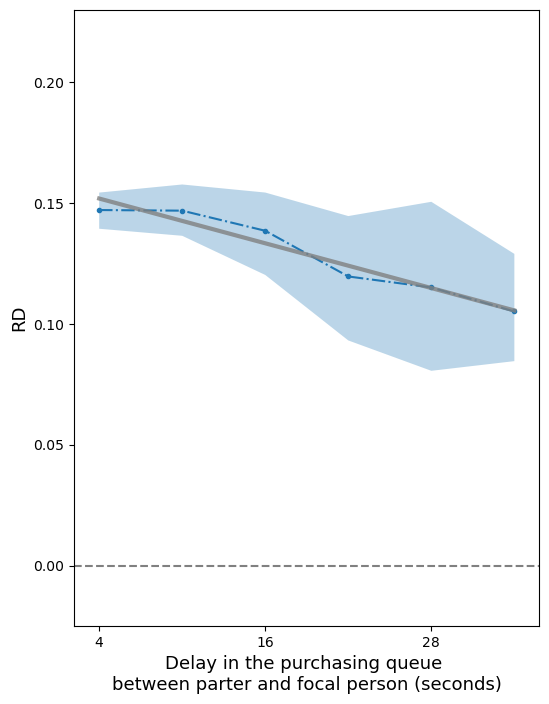

In [93]:
plt.subplots(1,1,figsize= (6,8))


gr = pd.DataFrame(list_viz_overall)

plt.plot(gr['bin'],gr['ATE'], linestyle = '-.', marker = 'o', markersize= 3)
plt.fill_between(gr['bin'], gr['lower_error'], gr['upper_error'], alpha = 0.3)

plt.xticks(gr['bin'], bins[:-1]);

plt.xlabel('Delay in the purchasing queue \nbetween parter and focal person (seconds)', fontsize= 13);
#plt.ylim([0,0.5])

slope, intercept, r, p, se = linregress(gr['bin'], gr['ATE'],
                                        alternative='two-sided')

if p<0.05:
    plt.plot(gr['bin'], intercept + slope*(gr['bin']),
               color = 'gray', linewidth = 3, alpha = 0.8)

else:
    plt.plot(gr['bin'], intercept + slope*(gr['bin']),
           color = 'gray',alpha = 0.3, linewidth = 3)


plt.xticks(gr['bin'][::2], [str(round(float(i+0.5))) for i in bins[:-1][::2]]);

plt.xlim(gr['bin'][::2][0]-0.3, gr['bin'].values[-1]+0.3)
plt.ylabel('RD', fontsize= 13)

plt.ylim([-0.025,0.23])

plt.hlines(0, gr['bin'][::2][0]-0.3, gr['bin'].values[-1]+0.3, linestyle = '--', color = 'gray')

plt.savefig(FIGURES_DIR+'fig9.pdf', bbox_inches='tight')

## e) Status

### e.1 partner

In [94]:
df['partner_student'] = df['partner_p_student'].apply(lambda x: 'student' if x>=0.5 else "staff")
df['focal_student'] = df['focal_p_student'].apply(lambda x: 'student' if x>=0.5 else "staff")

In [95]:
list_viz = []

for status in ['student', 'staff']:
    df_tmp = df.loc[df['partner_student'] == status]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(status, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))
    
    entry['status'] = status
    list_viz.append(entry)

student ATE = 16.78 %
staff ATE = 10.25 %


In [96]:
df_plot = pd.DataFrame(list_viz)

df_plot

treated_p  control_p       ATE  lower_error  upper_error   status
0   0.319005   0.151163  0.167842     0.160722     0.174795  student
1   0.302764   0.200263  0.102501     0.093917     0.110713    staff

In [97]:
randomized = pd.read_pickle('tmp/student_partner_randomized')

In [98]:
randomized

treated_p  control_p       ATE  lower_error  upper_error   status
0   0.134966   0.123209  0.011757     0.007126     0.016391  student
1   0.182209   0.173104  0.009105     0.002283     0.016042    staff

### e.2 focal

In [99]:
list_viz = []

for status in ['student', 'staff']:
    df_tmp = df.loc[df['focal_student'] == status]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(status, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))
    
    entry['status'] = status
    list_viz.append(entry)

student ATE = 17.0 %
staff ATE = 10.01 %


In [100]:
df_plot = pd.DataFrame(list_viz)

df_plot

treated_p  control_p       ATE  lower_error  upper_error   status
0   0.323763   0.153728  0.170035     0.163111     0.176514  student
1   0.295732   0.195682  0.100051     0.091696     0.108646    staff

In [101]:
randomized = pd.read_pickle('tmp/student_focal_randomized')

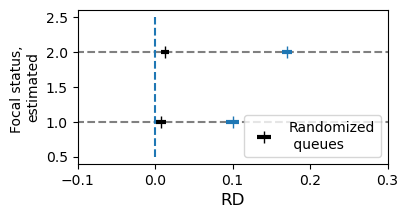

In [102]:
fix, axes = plt.subplots(1,1, figsize = (4,2))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(2-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[2-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    types.append(row['status'])
    
    baseline = randomized.loc[(randomized['status']==row['status'])].iloc[0]
    
    if c==0:
        plt.errorbar([baseline['ATE']],[2-c], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
    else:
        plt.errorbar([baseline['ATE']],[2-c], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
    c+=1
#plt.yticks(2-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,2.5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Focal status, \nestimated')
plt.legend()


plt.savefig(FIGURES_DIR+'fig11.pdf', bbox_inches='tight')

### e.3 cross

In [103]:
list_viz = []

for status1 in ['student', 'staff']:
    for status2 in ['student', 'staff']:
        df_tmp = df.loc[(df['focal_student'] == status1) & (df['partner_student'] == status2)]

        treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
        control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

        print(status, 'ATE =', round(100*(treated_p - control_p),2),'%')

        entry = {}

        entry['treated_p'] = treated_p
        entry['control_p'] = control_p

        entry['ATE'] = treated_p - control_p

        ys = []
        for iteration in range(1000):
            pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
            neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

            y_tmp = pos_tmp - neg_tmp

            ys.append(y_tmp)

        entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
        entry['upper_error'] = (np.percentile(np.array(ys),97.5))

        entry['status'] = status1 + 'X' + status2
        list_viz.append(entry)

staff ATE = 17.89 %
staff ATE = 12.15 %
staff ATE = 11.05 %
staff ATE = 9.66 %


In [104]:
df_plot = pd.DataFrame(list_viz)

df_plot

treated_p  control_p       ATE  lower_error  upper_error           status
0   0.328685   0.149812  0.178873     0.171576     0.185934  studentXstudent
1   0.296788   0.175267  0.121522     0.103876     0.139109    studentXstaff
2   0.268657   0.158171  0.110486     0.092700     0.126550    staffXstudent
3   0.304627   0.208014  0.096613     0.086599     0.106630      staffXstaff

In [105]:
randomized = pd.read_pickle('tmp/student_coss_randomized')

In [106]:
randomized

treated_p  control_p       ATE  lower_error  upper_error           status
0   0.131188   0.118384  0.012804     0.007777     0.018334  studentXstudent
1   0.166190   0.154802  0.011387    -0.002067     0.024185    studentXstaff
2   0.155325   0.148988  0.006337    -0.005921     0.017916    staffXstudent
3   0.187487   0.179017  0.008470     0.000942     0.016245      staffXstaff

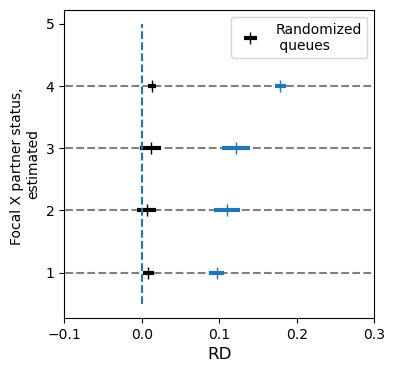

In [107]:
fix, axes = plt.subplots(1,1, figsize = (4,4))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(4-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[4-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    
    baseline = randomized.loc[(randomized['status']==row['status'])].iloc[0]
    if c==0:
        plt.errorbar([baseline['ATE']],[4-c], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
    else:
        plt.errorbar([baseline['ATE']],[4-c], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
    
    types.append(row['status'])
    c+=1
#plt.yticks(4-np.array(range(len(additions['LUNCH']))), [i.replace('X',' X ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Focal X partner status, \nestimated')
plt.legend()

plt.savefig(FIGURES_DIR+'fig12.pdf', bbox_inches='tight')

### Only a4c

In [108]:
def status_a4c_staff(x):
    if x==1:
        return 'student'
    if x==0:
        return 'staff'
    else:
        return 'unknown'

In [109]:
df['partner_student'] = df['partner_p_student'].apply(lambda x: 'student' if x>=0.5 else "staff")
df['focal_student'] = df['focal_p_student'].apply(lambda x: 'student' if x>=0.5 else "staff")

In [110]:
df['a4c_partner_student'] = df['partner_p_student'].apply(lambda x: status_a4c_staff(x))
df['a4c_focal_student'] = df['focal_p_student'].apply(lambda x: status_a4c_staff(x))

In [111]:
list_viz = []

for status in ['student', 'staff']:
    df_tmp = df.loc[df['a4c_partner_student'] == status]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(status, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))
    
    entry['status'] = status
    list_viz.append(entry)

student ATE = 10.73 %
staff ATE = 5.68 %


In [112]:
df_plot = pd.DataFrame(list_viz)

df_plot

treated_p  control_p       ATE  lower_error  upper_error   status
0   0.267206   0.159919  0.107287     0.048532     0.155870  student
1   0.223457   0.166667  0.056790     0.018519     0.095062    staff

In [113]:
randomized = pd.read_pickle('tmp/a4c_student_partner_randomized')

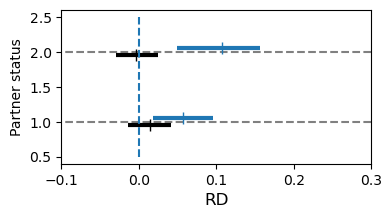

In [114]:

fix, axes = plt.subplots(1,1, figsize = (4,2))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(2-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[2-c+0.05], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    types.append(row['status'])
    
    baseline = randomized.loc[(randomized['status']==row['status'])].iloc[0]
    
    if c==0:
        plt.errorbar([baseline['ATE']],[2-c-0.05], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
    else:
        plt.errorbar([baseline['ATE']],[2-c-0.05], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
    c+=1
#plt.yticks(2-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,2.5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Partner status')
#plt.legend(loc = 'lower right')

plt.savefig(FIGURES_DIR+'fig13.pdf', bbox_inches='tight')

In [115]:
list_viz = []

for status in ['student', 'staff']:
    df_tmp = df.loc[df['a4c_focal_student'] == status]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(status, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))
    
    entry['status'] = status
    list_viz.append(entry)

student ATE = 14.15 %
staff ATE = 7.22 %


In [116]:
df_plot = pd.DataFrame(list_viz)

df_plot

treated_p  control_p       ATE  lower_error  upper_error   status
0   0.253097   0.111635  0.141462     0.095575     0.184071  student
1   0.211382   0.139219  0.072163     0.030894     0.115488    staff

In [117]:
randomized = pd.read_pickle('tmp/a4c_student_focal_randomized')

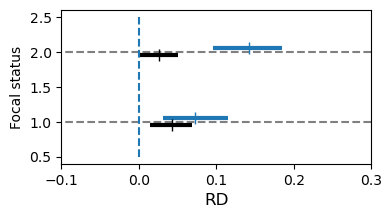

In [118]:
fix, axes = plt.subplots(1,1, figsize = (4,2))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(2-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[2-c+0.05], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    types.append(row['status'])
    
    baseline = randomized.loc[(randomized['status']==row['status'])].iloc[0]
    
    if c==0:
        plt.errorbar([baseline['ATE']],[2-c-0.05], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
    else:
        plt.errorbar([baseline['ATE']],[2-c-0.05], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
    c+=1
#plt.yticks(2-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,2.5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Focal status')
#plt.legend()


plt.savefig(FIGURES_DIR+'fig14.pdf', bbox_inches='tight')

## d) Gender

### d.1 partner

In [119]:
df['partner_gender'].value_counts()

unknown    94358
female      1322
male        1306
Name: partner_gender, dtype: int64

In [120]:
df['focal_gender'].value_counts()

unknown    94565
male        1318
female      1103
Name: focal_gender, dtype: int64

In [121]:
list_viz = []

for gender in ['male', 'female']:
    df_tmp = df.loc[df['partner_gender'] == gender]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(gender, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))
    
    entry['gender'] = gender
    list_viz.append(entry)

male ATE = 7.5 %
female ATE = 7.41 %


In [122]:
df_plot = pd.DataFrame(list_viz)

df_plot

treated_p  control_p       ATE  lower_error  upper_error  gender
0   0.292496   0.217458  0.075038     0.027565     0.122511    male
1   0.186082   0.111952  0.074130     0.036309     0.111989  female

In [123]:
randomized = pd.read_pickle('tmp/gender_partner_randomized')

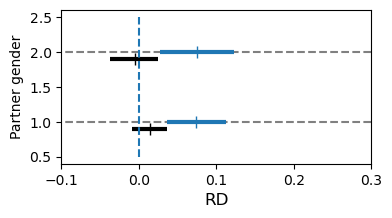

In [124]:

fix, axes = plt.subplots(1,1, figsize = (4,2))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(2-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[2-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    
    baseline = randomized.loc[(randomized['gender']==row['gender'])].iloc[0]
    
    if c==0:
        plt.errorbar([baseline['ATE']],[2-c-.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
    else:
        plt.errorbar([baseline['ATE']],[2-c-.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
        
        
    types.append(row['gender'])
    c+=1
#plt.yticks(2-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,2.5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Partner gender')
#plt.legend()

plt.savefig(FIGURES_DIR+'fig15.pdf', bbox_inches='tight')

### d.2 focal gender

In [125]:
list_viz = []

for gender in ['male', 'female']:
    df_tmp = df.loc[df['focal_gender'] == gender]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(gender, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))
    
    entry['gender'] = gender
    list_viz.append(entry)

male ATE = 9.26 %
female ATE = 12.02 %


In [126]:
df_plot = pd.DataFrame(list_viz)

df_plot

treated_p  control_p       ATE  lower_error  upper_error  gender
0   0.249235   0.156627  0.092609     0.053517     0.134557    male
1   0.208566   0.088339  0.120227     0.081937     0.163873  female

In [127]:
randomized = pd.read_pickle('tmp/gender_focal_randomized')

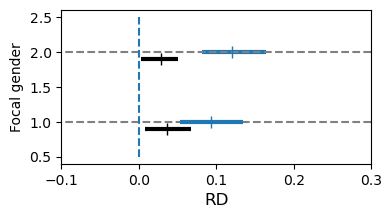

In [128]:
fix, axes = plt.subplots(1,1, figsize = (4,2))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(2-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[2-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    
    baseline = randomized.loc[(randomized['gender']==row['gender'])].iloc[0]
    
    if c==0:
        plt.errorbar([baseline['ATE']],[2-c-.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
    else:
        plt.errorbar([baseline['ATE']],[2-c-.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
        
        
    types.append(row['gender'])
    c+=1
#plt.yticks(2-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,2.5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Focal gender')
#plt.legend()

plt.savefig(FIGURES_DIR+'fig16.pdf', bbox_inches='tight')

### d.3 cross

In [129]:
list_viz = []

for gender1 in ['male', 'female']:
    for gender2 in ['male', 'female']:
        df_tmp = df.loc[(df['focal_gender'] == gender1) & (df['partner_gender'] == gender2)]

        try:
            treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
        except KeyError as e:
            treated_p = 0
        
        try:
            control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]
        except KeyError as e:
            control_p = 0
        print(gender1, gender2, 'ATE =', round(100*(treated_p - control_p),2),'%')

        entry = {}

        entry['treated_p'] = treated_p
        entry['control_p'] = control_p

        entry['ATE'] = treated_p - control_p

        ys = []
        for iteration in range(1000):
            try:
                pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
            except KeyError as e:
                pos_tmp = 0
                
            try:
                neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   
            except KeyError as e:
                neg_tmp = 0
                
            y_tmp = pos_tmp - neg_tmp

            ys.append(y_tmp)

        entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
        entry['upper_error'] = (np.percentile(np.array(ys),97.5))

        entry['gender'] = gender1 + 'X' + gender2
        list_viz.append(entry)

male male ATE = 11.73 %
male female ATE = 5.85 %
female male ATE = 1.72 %
female female ATE = 7.35 %


In [130]:
df_plot = pd.DataFrame(list_viz)

df_plot

treated_p  control_p       ATE  lower_error  upper_error         gender
0   0.323810   0.206522  0.117288    -0.009524     0.228571      maleXmale
1   0.095238   0.036697  0.058541    -0.015873     0.142857    maleXfemale
2   0.043478   0.026316  0.017162    -0.086957     0.130435    femaleXmale
3   0.136905   0.063380  0.073524     0.011905     0.136905  femaleXfemale

Text(0, 0.5, 'Focal X partner gender')

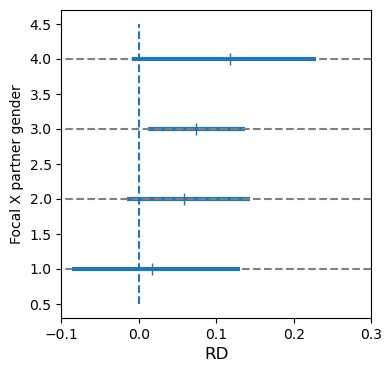

In [131]:
fix, axes = plt.subplots(1,1, figsize = (4,4))

types = []

c = 0
for cnt,row in df_plot.sort_values(by = 'ATE', ascending = False).iterrows():
    plt.hlines(4-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[4-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    types.append(row['gender'])
    c+=1
#plt.yticks(4-np.array(range(len(additions['LUNCH']))), [i.replace('X',' X ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,4.5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Focal X partner gender')

## e) Age

In [132]:
df = pd.read_pickle('tmp/3_meals_matched_situations')

In [133]:
df['partner_age'] = df['partner_age'].replace('unknown',np.nan).astype(float)
df['focal_age'] = df['focal_age'].replace('unknown',np.nan).astype(float)

In [134]:
def bin_age_quarters(x):
    if x<=21:
        return "<=21"
    elif x<=26:
        return "22-26"
    elif x<=36:
        return "27-36"
    elif x>36:
        return ">36"
    else:
        return np.nan


def bin_age_thirds(x):
    if x<=22:
        return "<=22"
    elif x<=32:
        return "23-32"
    elif x>32:
        return ">32"
    else:
        return np.nan
    
def bin_age_half(x):
    if x<=26:
        return "<=26"
    elif x>26:
        return ">26"
    else:
        return np.nan

In [135]:
df['focal_age_binned'] = (df['timestamp'].apply(lambda x: x.year) - \
        df['focal_age']).apply(bin_age_thirds)
df['partner_age_binned'] = (df['timestamp'].apply(lambda x: x.year) - \
        df['partner_age']).apply(bin_age_thirds)

In [136]:
df['focal_age_binned'].value_counts().index

Index(['>32', '23-32', '<=22'], dtype='object')

### e.1 partner age

In [137]:
list_viz = []

for age in ['<=22', '23-32', '>32']:
    df_tmp = df.loc[df['partner_age_binned'] == age]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(age, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))
    
    entry['age'] = age
    list_viz.append(entry)

<=22 ATE = 12.04 %
23-32 ATE = 8.11 %
>32 ATE = 4.98 %


In [138]:
df_plot = pd.DataFrame(list_viz)

In [139]:
randomized = pd.read_pickle('tmp/partner_age_randomized')

In [140]:
randomized

treated_p  control_p       ATE  lower_error  upper_error    age
0   0.081470   0.083333 -0.001864    -0.030351     0.028754   <=22
1   0.137405   0.146026 -0.008621    -0.049618     0.032443  23-32
2   0.121472   0.101250  0.020222    -0.008589     0.051534    >32

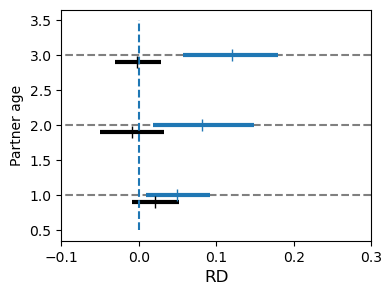

In [141]:

fix, axes = plt.subplots(1,1, figsize = (4,3))

types = []

c = 0
for cnt,row in df_plot.iterrows():
    plt.hlines(3-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[3-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    
    baseline = randomized.loc[(randomized['age']==row['age'])].iloc[0]
    
    if c==0:
        plt.errorbar([baseline['ATE']],[3-c-.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
    else:
        plt.errorbar([baseline['ATE']],[3-c-.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
        
        
    types.append(row['age'])
    c+=1
#plt.yticks(3-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,3.5, linestyle = '--')

#plt.legend(loc = 'lower right')
plt.xlabel('RD', fontsize =12)
plt.ylabel('Partner age')

plt.savefig(FIGURES_DIR+'fig17.pdf', bbox_inches='tight')

### e.2 focal age

In [142]:
list_viz = []

for age in ['<=22', '23-32', '>32']:
    df_tmp = df.loc[df['focal_age_binned'] == age]
    
    treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
    control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]

    print(age, 'ATE =', round(100*(treated_p - control_p),2),'%')
    
    entry = {}

    entry['treated_p'] = treated_p
    entry['control_p'] = control_p

    entry['ATE'] = treated_p - control_p
    
    ys = []
    for iteration in range(1000):
        pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
        neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   

        y_tmp = pos_tmp - neg_tmp

        ys.append(y_tmp)

    entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
    entry['upper_error'] = (np.percentile(np.array(ys),97.5))
    
    entry['age'] = age
    list_viz.append(entry)

<=22 ATE = 17.72 %
23-32 ATE = 13.18 %
>32 ATE = 4.04 %


In [143]:
df_plot = pd.DataFrame(list_viz)

In [144]:
randomized = pd.read_pickle('tmp/focal_age_randomized')

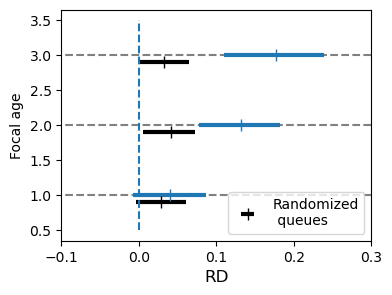

In [145]:
fix, axes = plt.subplots(1,1, figsize = (4,3))

types = []

c = 0
for cnt,row in df_plot.iterrows():
    plt.hlines(3-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[3-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    
    baseline = randomized.loc[(randomized['age']==row['age'])].iloc[0]
    
    if c==0:
        plt.errorbar([baseline['ATE']],[3-c-.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3, label = 'Randomized\n queues')
    else:
        plt.errorbar([baseline['ATE']],[3-c-.1], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                                                  np.array([baseline['upper_error']- baseline['ATE']])),
                 fmt = '|', markersize= 8,color = 'black', linewidth = 3)
        
        
    types.append(row['age'])
    c+=1
#plt.yticks(3-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,3.5, linestyle = '--')

plt.legend(loc = 'lower right')
plt.xlabel('RD', fontsize =12)
plt.ylabel('Focal age')

plt.savefig(FIGURES_DIR+'fig18.pdf', bbox_inches='tight')

### e.3 cross

In [146]:
df['focal_age_binned'] = (df['timestamp'].apply(lambda x: x.year) - \
        df['focal_age']).apply(bin_age_half)
df['partner_age_binned'] = (df['timestamp'].apply(lambda x: x.year) - \
        df['partner_age']).apply(bin_age_half)

In [147]:
list_viz = []

for age1 in ['<=26', '>26']:
    for age2 in ['<=26', '>26']:
        df_tmp = df.loc[(df['focal_age_binned'] == age1) & (df['partner_age_binned'] == age2)]

        try:
            treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
        except:
            continue
            treated_p = 0
        
        try:
            control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]
        except:
            continue
            control_p = 0
        print(age1, age2, 'ATE =', round(100*(treated_p - control_p),2),'%')

        entry = {}

        entry['treated_p'] = treated_p
        entry['control_p'] = control_p

        entry['ATE'] = treated_p - control_p

        ys = []
        for iteration in range(1000):
            try:
                pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
            except KeyError as e:
                pos_tmp = 0
                
            try:
                neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   
            except KeyError as e:
                neg_tmp = 0
                
            y_tmp = pos_tmp - neg_tmp

            ys.append(y_tmp)

        entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
        entry['upper_error'] = (np.percentile(np.array(ys),97.5))

        entry['age'] = age1 + 'X' + age2
        list_viz.append(entry)

<=26 <=26 ATE = 8.49 %
<=26 >26 ATE = -0.74 %
>26 <=26 ATE = 11.23 %
>26 >26 ATE = 9.27 %


In [148]:
df_plot = pd.DataFrame(list_viz)

Text(0, 0.5, 'Focal X partner age')

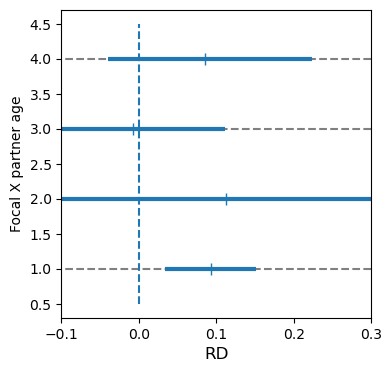

In [149]:

fix, axes = plt.subplots(1,1, figsize = (4,4))

types = []

c = 0
for cnt,row in df_plot.iterrows():
    plt.hlines(4-cnt, -1,4, color = 'gray', linestyle = '--')
    plt.errorbar([row['ATE']],[4-c], xerr = (np.array([row['ATE'] - row['lower_error']]), np.array([row['upper_error']- row['ATE']])),
                 fmt = '|', markersize= 8,color = 'tab:blue', linewidth = 3)
    types.append(row['age'])
    c+=1
#plt.yticks(4-np.array(range(len(additions['LUNCH']))), [i.replace('_',' ').capitalize() for i in types]);

plt.xlim([-0.1,0.3])

plt.vlines(0,0.5,4.5, linestyle = '--')

plt.xlabel('RD', fontsize =12)
plt.ylabel('Focal X partner age')

### f) student x foods

In [150]:
df = pd.read_pickle('tmp/3_meals_matched_situations')

In [151]:
df['partner_student'] = df['partner_p_student'].apply(lambda x: 'student' if x>=0.5 else "staff")
df['focal_student'] = df['focal_p_student'].apply(lambda x: 'student' if x>=0.5 else "staff")

In [152]:
list_viz = []

for c in [True, False]:
    df_tmp = df.loc[((df['focal_student'] == 'student') & (df['partner_student'] == 'student'))==c]
    print(len(df_tmp))

49472
47514


In [153]:
list_viz = []

for c in [True, False]:
    df_t = df.loc[((df['focal_student'] == 'student') & (df['partner_student'] == 'student'))==c]
        
    for meal in ['BREAKFAST', 'LUNCH', 'AFTERNOON SNACK']:
        for addition in additions[meal]:
            df_tmp = df_t.loc[(df_t['MEAL']==meal) & (df_t['addition']==addition)]

            try:
                treated_p = df_tmp.loc[df_tmp['exposure']==1]['outcome'].value_counts(normalize = True)[1]
                control_p = df_tmp.loc[df_tmp['exposure']==0]['outcome'].value_counts(normalize = True)[1]
            except:
                print('no data:',meal, addition)
                continue

            print(c, meal, addition,  'ATE =', round(100*(treated_p - control_p),2),'%')

            entry = {}
            
            entry['contingency'] = pd.crosstab(df_tmp['exposure'],df_tmp['outcome'], margins = False)
            entry['ATE'] = treated_p - control_p

            entry['RR'] = treated_p/control_p

            ys = []
            ys_rr = []
            for iteration in range(1000):
                try:
                    pos_tmp = df_tmp.loc[df_tmp['exposure']==1].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]
                    neg_tmp = df_tmp.loc[df_tmp['exposure']==0].sample(len(df_tmp.loc[df_tmp['exposure']==1]), replace = True)['outcome'].value_counts(normalize = True)[1]   
                except:
                    continue
                y_tmp = pos_tmp - neg_tmp

                ys.append(y_tmp)
                ys_rr.append(pos_tmp/neg_tmp)

            entry['lower_error'] = (np.percentile(np.array(ys), 2.5))
            entry['upper_error'] = (np.percentile(np.array(ys),97.5))

            entry['lower_error_rr'] = (np.percentile(np.array(ys_rr), 2.5))
            entry['upper_error_rr'] = (np.percentile(np.array(ys_rr),97.5))

            entry['meal'] = meal
            entry['addition'] = addition
            entry['type'] = c

            list_viz.append(entry)   


True BREAKFAST dessert ATE = 9.02 %
True BREAKFAST fruit ATE = 9.23 %
True BREAKFAST pastry ATE = 18.22 %
True LUNCH condiment ATE = 26.59 %
True LUNCH dessert ATE = 15.34 %
True LUNCH fruit ATE = 15.33 %
True LUNCH pastry ATE = 15.49 %
True LUNCH salad ATE = 17.16 %
True LUNCH soft drink ATE = 14.03 %
True LUNCH soup ATE = 20.91 %
True AFTERNOON SNACK dessert ATE = 7.72 %
True AFTERNOON SNACK fruit ATE = 10.32 %
True AFTERNOON SNACK pastry ATE = 27.35 %
False BREAKFAST dessert ATE = 4.73 %
False BREAKFAST fruit ATE = 6.83 %
False BREAKFAST pastry ATE = 7.19 %
False LUNCH condiment ATE = 17.72 %
False LUNCH dessert ATE = 11.75 %
False LUNCH fruit ATE = 13.85 %
False LUNCH pastry ATE = 6.89 %
False LUNCH salad ATE = 8.82 %
False LUNCH soft drink ATE = 5.08 %
False LUNCH soup ATE = 15.37 %
False AFTERNOON SNACK dessert ATE = 7.44 %
False AFTERNOON SNACK fruit ATE = 7.35 %
False AFTERNOON SNACK pastry ATE = 13.54 %


In [154]:
df_plot = pd.DataFrame(list_viz)

In [155]:
df_plot.iloc[5]['contingency']

outcome      0     1
exposure            
0         6019  1425
1         4890  2572

In [156]:
corrected_alpha = 1 - math.pow((1 - 0.01),(1/13))
print(corrected_alpha)

0.0007728039910219753


In [157]:
randomized = pd.read_pickle('tmp/randomized_estimates_status_x_foods')

LUNCH
condiment 639.2313624804952 4.996409982676135e-137 4
dessert 151.45677883248396 9.920519960164493e-32 4
fruit 633.499871953909 8.69633244571816e-136 4
pastry 291.4149168540808 7.70028902449417e-62 4
salad 223.9546151575538 2.641584093437701e-47 4
soft drink 228.06439826358502 3.445597790637101e-48 4
soup 824.8138240153246 3.238407897246879e-177 4


BREAKFAST
dessert 29.85958000953324 5.2273867857931396e-06 4
fruit 32.55216646563611 1.4751363084969488e-06 4
pastry 208.57849677357223 5.372036183920236e-44 4


AFTERNOON SNACK
dessert 22.80799377608406 0.000138314824010565 4
fruit 11.269771094010022 0.023693746432759306 4
pastry 290.3625310651274 1.2985815280053112e-61 4




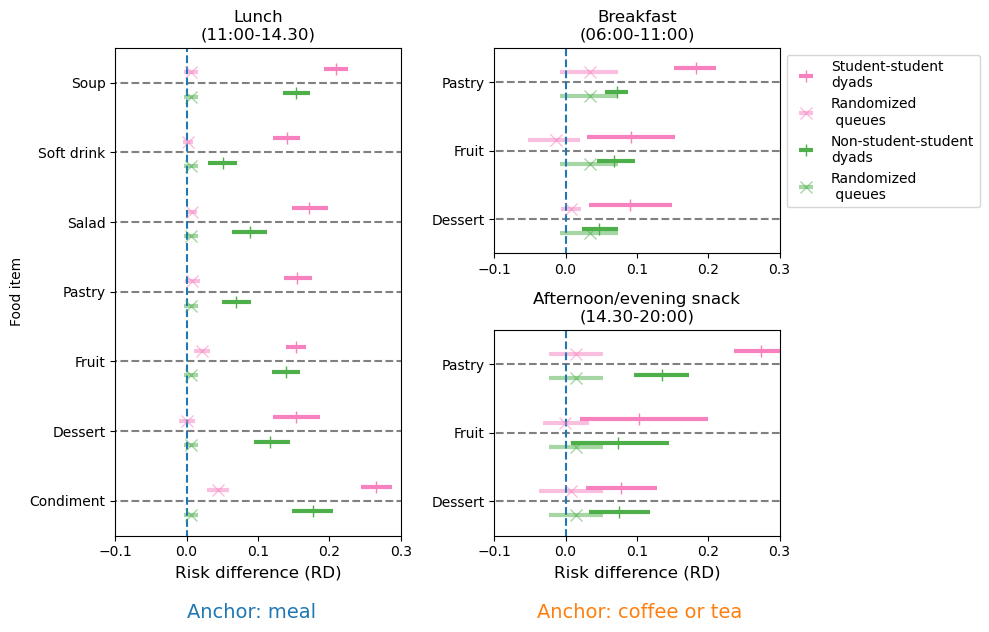

In [158]:
plt.figure(figsize = (10,6))

for cnt,meal in enumerate(['LUNCH', 'BREAKFAST','AFTERNOON SNACK']):
    if cnt==0:
        sbplt = plt.subplot(2,2,(1,3))
        sbplt.set_ylim([-0.5,6.5])
    if cnt==1:
        sbplt = plt.subplot(2,2,2)
        sbplt.set_ylim([-0.5,2.5])
    if cnt==2:
        sbplt = plt.subplot(2,2,4)
        sbplt.set_ylim([-0.5,2.5])
        
    types = []

    c = 0
    
    tables_1 = []
    for cnt,row in (df_plot.loc[(df_plot['meal']==meal) & (df_plot['type'])].reset_index().iterrows()):
        sbplt.hlines(cnt, -1,4, color = 'gray', linestyle = '--')
    
        baseline = randomized.loc[(randomized['type']) & (randomized['meal']==meal) & (randomized['addition']==row['addition'])].iloc[0]
        
        if meal=='BREAKFAST' and cnt==0:
            sbplt.errorbar([row['ATE']],[c+0.2], xerr = (np.array([row['ATE'] - row['lower_error']]), 
                     np.array([row['upper_error']- row['ATE']])),
                     fmt = '|', markersize= 8,color = '#f781bf', linewidth = 3, label = 'Student-student\ndyads')
            
            sbplt.errorbar([baseline['ATE']],[c+0.15], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                     np.array([baseline['upper_error']- baseline['ATE']])),
                     fmt = 'x', markersize= 8,color = '#f781bf',alpha = 0.5, linewidth = 3, label = 'Randomized\n queues')
            
        else:
            sbplt.errorbar([row['ATE']],[c+0.2], xerr = (np.array([row['ATE'] - row['lower_error']]), 
                     np.array([row['upper_error']- row['ATE']])),
                     fmt = '|', markersize= 8,color = '#f781bf', linewidth = 3)
            
            sbplt.errorbar([baseline['ATE']],[c+0.15], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                     np.array([baseline['upper_error']- baseline['ATE']])),
                     fmt = 'x', markersize= 8,color = '#f781bf',alpha = 0.5,  linewidth = 3)
        
        types.append(row['addition'])
        tables_1.append(row['contingency'])
        c+=1
        
    types = []

    c = 0
    
    tables_2 = []
    for cnt,row in df_plot.loc[(~randomized['type']) & ((df_plot['meal']==meal)) & (~(df_plot['type']))].reset_index().iterrows():

        if meal=='BREAKFAST' and cnt==0:
            sbplt.errorbar([row['ATE']],[c-0.15], xerr = (np.array([row['ATE'] - row['lower_error']]), 
                     np.array([row['upper_error']- row['ATE']])),
                     fmt = '|', markersize= 8,color = '#4daf4a', linewidth = 3, label = 'Non-student-student\ndyads')
            
            sbplt.errorbar([baseline['ATE']],[c-0.2], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                     np.array([baseline['upper_error']- baseline['ATE']])),
                     fmt = 'x', markersize= 8,color = '#4daf4a', alpha = 0.5,linewidth = 3, label = 'Randomized\n queues')
            
            sbplt.legend( bbox_to_anchor = (1,1))
        else: 
            sbplt.errorbar([row['ATE']],[c-0.15], xerr = (np.array([row['ATE'] - row['lower_error']]), 
                     np.array([row['upper_error']- row['ATE']])),
                     fmt = '|', markersize= 8,color = '#4daf4a', linewidth = 3)
            sbplt.errorbar([baseline['ATE']],[c-0.2], xerr = (np.array([baseline['ATE'] - baseline['lower_error']]), 
                     np.array([baseline['upper_error']- baseline['ATE']])),
                     fmt = 'x', markersize= 8,color = '#4daf4a', alpha = 0.5, linewidth = 3)

        types.append(row['addition'])
        tables_2.append(row['contingency'])
        c+=1
        
    
        
    sbplt.set_yticks(np.array(range(len(additions[meal]))))
    sbplt.set_yticklabels([i.replace('_',' ').capitalize() for i in types])

    sbplt.set_xlim([-0.1,0.3])
    

    sbplt.vlines(0,-1,7, linestyle = '--')

    if meal!='BREAKFAST':
        sbplt.set_xlabel('Risk difference (RD)', fontsize =12)
    

        
    if meal =='AFTERNOON SNACK':
        sbplt.set_title('AFTERNOON/EVENING SNACK'.lower().capitalize()+'\n('+times[meal]+')')
    else:
        sbplt.set_title(meal.lower().capitalize()+'\n('+times[meal]+')')
    
    if meal == 'LUNCH':
        sbplt.set_ylabel('Food item')
        
    print(meal)
    p_values = []
    for i in range(len(tables_1)):
        g, p, dof, expctd = chi2_contingency(np.array(((tables_1[i].values), (tables_2[i].values))), correction = True)
        print(types[i],g,p, dof)
        if p<corrected_alpha:
            p_values.append('')
        else:
            p_values.append('')
    print('\n')
   
    sbplt.set_yticklabels([i.replace('_',' ').capitalize()+p_values[counter] for counter,i in enumerate(types)])
    
plt.tight_layout()

plt.text(x = -0.53, y = -1.7, s='Anchor: meal', fontsize= 14, color = 'tab:blue') 
plt.text(x = -0.04, y = -1.7, s='Anchor: coffee or tea', fontsize= 14, color = 'tab:orange') 


plt.savefig(FIGURES_DIR+'fig19.pdf', bbox_inches='tight')

In [159]:
df_plot.loc[df_plot['type']]

contingency       ATE        RR  \
0   outcome     0   1
exposure         
0         ...  0.090197  6.231405   
1   outcome     0   1
exposure         
0         ...  0.092282  5.152672   
2   outcome      0    1
exposure           
0     ...  0.182185  1.586121   
3   outcome      0    1
exposure           
0     ...  0.265902  7.560026   
4   outcome     0    1
exposure          
0       ...  0.153414  5.093098   
5   outcome      0     1
exposure            
0   ...  0.153250  1.800558   
6   outcome      0    1
exposure           
0     ...  0.154938  4.079201   
7   outcome      0    1
exposure           
0     ...  0.171559  5.339436   
8   outcome      0    1
exposure           
0     ...  0.140256  2.919126   
9   outcome      0     1
exposure            
0   ...  0.209125  2.090889   
10  outcome     0   1
exposure         
0         ...  0.077203  2.060526   
11  outcome    0   1
exposure        
0         86...  0.103204  2.582456   
12  outcome     0    1
exposure          
0       ...  0.273516  2.463551   

    lower_error  upper_error  lower_error_rr  upper_error_rr             meal  \
0      0.033058     0.148760        2.000000       18.250000        BREAKFAST   
1      0.030534     0.152672        2.000000       19.000000        BREAKFAST   
2      0.152095     0.211071        1.469147        1.715072        BREAKFAST   
3      0.243616     0.288062        6.132653        9.606628            LUNCH   
4      0.120411     0.186490        3.470252        8.375347            LUNCH   
5      0.139772     0.166845        1.702898        1.900959            LUNCH   
6      0.135845     0.175508        3.359556        5.176471            LUNCH   
7      0.147901     0.198767        4.118918        7.143773            LUNCH   
8      0.121334     0.159502        2.531521        3.461137            LUNCH   
9      0.191968     0.225934        1.967094        2.235431            LUNCH   
10     0.028571     0.128571        1.296147        3.500000  AFTERNOON SNACK   
11     0.020789     0.200000        1.166071        8.500000  AFTERNOON SNACK   
12     0.235480     0.312566        2.137677        2.895620  AFTERNOON SNACK   

      addition  type  
0      dessert  True  
1        fruit  True  
2       pastry  True  
3    condiment  True  
4      dessert  True  
5        fruit  True  
6       pastry  True  
7        salad  True  
8   soft drink  True  
9         soup  True  
10     dessert  True  
11       fruit  True  
12      pastry  True

In [160]:
tables_1[-3].values[1,1]/(tables_1[-3].values[1,0] + tables_1[-3].values[1,1]) - \
tables_1[-3].values[0,1]/(tables_1[-3].values[0,0] + tables_1[-3].values[0,1])

0.07720306513409961

In [161]:
tables_2[-3].values[1,1]/(tables_2[-3].values[1,0] + tables_2[-3].values[1,1]) - \
tables_2[-3].values[0,1]/(tables_2[-3].values[0,0] + tables_2[-3].values[0,1])

0.07442687860442429

In [162]:
tables_2[-3].values

array([[361,  22],
       [316,  48]])

In [163]:
tables_1[-3].values

array([[242,  19],
       [238,  42]])

In [164]:
tables_1[-1].values[0,1] / (tables_1[-1].values[0,0] + tables_1[-1].values[0,1])

0.18688524590163935